In [1]:
### Reed Whitcraft
### Module 04 Project
### Monday, June 03, 2019 - Saturday, June 8, 2019

# Introduction - CNNs for Image Classification (keras)

## Project Background

While scouring the web for appropriate databases, and without a predetermined problem or focus, I had to choose between three main subdomains:

- Traditional Classification/Regression tasks
- Computer Vision
- Text Classification/NLP

Unfortunately, having already been introduced to the [dog breed identification database](https://www.kaggle.com/c/dog-breed-identification), I was barred from working with these four-legged friends.  And, after not being able to find a text classification dataset and problem that called me, I settled on computer vision/image classification.

## Database Selection - Fruits 360

For this image classification endeavor, I selected the [Fruits 360 Dataset](https://www.kaggle.com/moltean/fruits) on Kaggle, which is a high-quality dataset of images containing fruits (with one fruit per image).

### Dataset Features

- **Classes**: 103 (fruits) - however, I only worked with 40 fruits
- **Total Images**: 71,125
- **Training Images**: 53,177
- **Testing Images**: 17,845
- **Image Size**: 100x100 pixels
- **Image Details**: Color, .jpg filetype

### Directory Structure

The initial dataset had the following directory structure, which was kept because keras provides the option to create your validation dataset from your training dataset, without the need to create a validation directory and populate it with data.

- data/
    - test/
        - apple/
            - apple.jpg
        - apricot/
            - apricot.jpg
        - ...
    - training/
        - apple/
            - apple.jpg
        - apricot/
            - apricot.jpg
        - ...       

## Model Architecture

- Start off with input image (resized, color or greyscaled)
- Apply filters or feature maps to image (convolutional layer)
- Break up linearity of image using an activation (rectifier function - relu)
- Pooling layer (Maxpooling) to prepare CNN (spacial invariance) to detect different orientations/positions of object in image
- Flatten pooled feature map & insert into articial neural network


- Step 1: Convolution Operation & Activation Layer
- Step 2: Pooling Layer
- Step 3: Dropout Layer **(Technically, Optional...)**
- Step 4: **Repeat Steps 1-3** (Combined, we count these as a single hidden layer)
- Step 5: Flatten Layer
- Step 6: Dropout Layer
- Step 7: Dense Layer / Final Dense Layer (Full Connection)

## Model Variations

### Parameter Tuning

Finding the right model is an iterative process, so I'll be tuning a couple parameters when building a Sequential model in keras:

- **Layers**: 1, 2, 3, 4
- **Activation**: relu, tanh
- **Padding**: valid (reduces input size), same (adds padding to maintain input size)
- **Dropout (Rate)**: 0, 20, 30, 50
- **Optimizer**: RMSprop, Adam

### Model Lifecycle

A model's lifecycle will follow: 

- **Create**: Selecting different parameter values, and building model
- **Compile**: Set loss function, optimizer, and metrics to measure (accuracy)
- **Fit**: Apply model to training data (``model.fit_generator(...)``), and plot/record training & validation loss and accuracy metrics
- **Evaluate/Predict**: Apply model to testing data, and plot/record test loss and accuracy metrics, and view confusion matrix of correct/incorrect class predictions.

### Record Model

At the end of each model's lifecycle, I'll be recording: 

- Model (variable) name
- Selected parameters and their values
- Training accuracy/loss
- Validation accuracy/loss
- Testing accuracy/loss

After the first batch of random model selections, successive models will be further tuned based on what parameters resulted in favorable training/validation (and ultimately, testing) accuracy/loss scores.

# Data Import & Preprocessing

## Libraries

In [302]:
# core libraries
import numpy as np
import pandas as pd
import math
import random

# directory nagivation, path libraries
import os
from pathlib import Path

from sklearn.preprocessing import LabelEncoder

# cnn, keras
from keras import layers
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, Dropout, MaxPooling2D
from keras import models
from keras.models import Model
from keras.models import Sequential

# optimizers
from keras import optimizers
from keras.optimizers import adam

# keras image preprocessing, data generators
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

# rendering images
from matplotlib.image import imread
from PIL import Image

# plotting, visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# interactive notebook library
from ipywidgets import interact, interactive

np.random.seed(123)

## Loading & Previewing Data

### Setting Paths

In [303]:
# list directory path, ignoring hidden files
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [33]:
path = 'data/training'
train_dir = 'data/training'
test_dir = 'data/test'
dirs = list(listdir_nohidden(path))
print(dirs)

['huckleberry', 'pear', 'strawberry', 'avocado', 'pomegranate', 'dates', 'kiwi', 'lemon', 'guava', 'mandarine', 'grape_blue', 'raspberry', 'grapefruit_pink', 'redcurrant', 'tomato_cherry_red', 'chestnut', 'plum', 'cherry', 'hazelnut', 'nectarine', 'clementine', 'pepper_red', 'cantaloupe', 'apple_red', 'mango', 'cocos', 'mulberry', 'kumquats', 'apricot', 'cactus_fruit', 'limes', 'banana', 'papaya', 'walnut', 'pineapple', 'passion_fruit', 'tomato', 'orange', 'grape_white', 'peach']


### Preview Images

#### Selecting Random Image From Each Class (Folder)

In [304]:
single_images = []

for folder_path in dirs:
    full_folder_path = Path(train_dir + '/' + folder_path)
    rand_img = random.choice(list(full_folder_path.glob('*.jpg')))
    img_array = imread(rand_img)
    single_images.append({'fruit': folder_path, 'img_array': img_array, 'img': rand_img})

#### View First 9 Images Of A Class (Folder)

In [385]:
folder_names = os.listdir(train_dir)
@interact

def preview_images(folder=folder_names):
    folder_path = train_dir + '/' + folder
    imgs = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]
    imgs_10 = imgs[0:9]
    plt.figure(figsize=(16,12))
    for i in range(9):        
        plt.subplot(330 + 1 + i)
        image = imread(folder_path + '/' + imgs_10[i])
        plt.imshow(image)
    plt.show()

interactive(children=(Dropdown(description='folder', options=('huckleberry', 'pear', 'strawberry', 'avocado', …

### Train, Validation, Test Generators

#### Setting parameter values common for all data/models

In [35]:
batch_size=32
img_height = 64
img_width = 64
num_train_samples = 16674
num_validation_samples = 4156
num_test_samples = 6999
num_classes = 40

#### Creating Train & Test Image Data Generators

We'll be rescaling the pixel values of images from (0,255) to (0,1), and potentially greyscaling images to reduce dimensionality.

In [36]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                  validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 16674 images belonging to 40 classes.
Found 4156 images belonging to 40 classes.
Found 6999 images belonging to 40 classes.


# Modeling & Plotting Methods

### 1, 2, & 3 Layer Models

Methods for quickly creating CNNs with different activations, dropout rates, optimizers, and layers

In [189]:
def model_1_layer(activation='relu', optimizer=optimizers.RMSprop(lr=1e-4), verbose=False, dropout=False, dropout_rate=0.25):
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation=activation, input_shape=(64,64,3)))
    model.add(MaxPooling2D((2,2)))
    if dropout == True:
        model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['acc'])
    if verbose == True:
        print(model.summary())
    return model

def model_2_layer(activation='relu', optimizer=optimizers.RMSprop(lr=1e-4), verbose=False, dropout=False, dropout_rate=0.25):
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation=activation, input_shape=(64,64,3)))
    model.add(MaxPooling2D((2,2)))
    if dropout == True:
        model.add(Dropout(dropout_rate))
    model.add(Conv2D(64, (3,3), activation=activation))
    model.add(MaxPooling2D((2,2)))
    if dropout == True:
        model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    if dropout == True:
        model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['acc'])
    if verbose == True:
        print(model.summary())
    return model

def model_3_layer(activation='relu', optimizer=optimizers.RMSprop(lr=1e-4), verbose=False, dropout=False, dropout_rate=0.25):
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation=activation, input_shape=(64,64,3)))
    model.add(MaxPooling2D((2,2)))
    if dropout == True:
        model.add(Dropout(dropout_rate))
    model.add(Conv2D(64, (3,3), activation=activation))
    model.add(MaxPooling2D((2,2)))
    if dropout == True:
        model.add(Dropout(dropout_rate))
    model.add(Conv2D(128, (3,3), activation=activation))
    model.add(MaxPooling2D((2,2)))
    if dropout == True:
        model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    if dropout == True:
        model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['acc'])
    if verbose == True:
        print(model.summary())
    return model

### Fit Model (keras ``model.fit_generator(...)``)

Requires model, and optional arguments of epochs, steps per epochs, and whether or not the training accuracy and loss should be plotted.

In [316]:
## steps = ceil(num_train_samples / batch_size)
def fit_model(model, epochs=10, plot=False, steps_per_epoch=None, verbose=2):
    if steps_per_epoch == None:
        steps_per_epoch = math.ceil(num_train_samples / batch_size)
    history = model.fit_generator(train_generator,
                                 steps_per_epoch=steps_per_epoch,
                                 epochs=epochs,
                                 validation_data=validation_generator,
                                  shuffle=False, 
                                 validation_steps=20,
                                 verbose=verbose)
    if plot == True:
        plot_training_accuracy_and_loss(history)
    return history

### Plot Train/Validation Accuracy & Loss

In [328]:
def plot_training_accuracy_and_loss(history):
    final_loss = history.history['loss'][-1]
    final_acc = history.history['acc'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_val_acc = history.history['val_acc'][-1]
    
    print("TRAIN LOSS: ", final_loss)
    print("TRAIN ACC: ", final_acc)
    print("VAL LOSS: ", final_val_loss)
    print("VAL ACC: ", final_val_acc)
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig = plt.gcf()
    fig.set_size_inches(16, 4)
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training & validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training & validation loss')
    plt.legend()
    plt.show()

### Save Model

In [192]:
# save_model(model, 'Baseline_CNN_0605.h5')
def save_model(model, model_filename):
    model.save(model_filename)

### Evaluate Model On Test

#### keras ``model.evaluate_generator(...)`` and ``model.predict_generator(...)``

Takes model and test generator as arguments, then calls the appropriate keras functions & records the test accuracy/loss.

In [307]:
def evaluate_model_on_test(model, test_generator):
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator))
    y_hat_test = model.predict_generator(test_generator, steps=219)
    yy_hat_test = np.argmax(y_hat_test, axis=1)
    print('Generated {} predictions'.format(len(y_hat_test)))
    print("Test Acc:", test_acc)
    print("Test Loss:", test_loss)

### Confusion Matrix Function - a la [scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [452]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    classes = np.sort(classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    fig.set_figheight(18)
    fig.set_figwidth(18)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] != 0:
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.show()
    return ax

### Recording Models

Instantiate empty array, which will contain dictionaries of model attributes that can be converted into a dataframe for comparison.

In [242]:
models_list = []
model_columns = ['model_name', 'activation', 'optimizer', 'layers', 
                 'padding', 'dropout', 'dropout_rate', 'epochs',
                'train_loss', 'train_acc', 'val_loss', 'val_acc',
                'test_loss', 'test_acc']

# Modeling - V1

## Instantiating 1,2, & 3 Layer Models (relu & tanh)

#### relu

Six models using 1,2, and 3 convolutional layers, with and without a dropout layer

In [87]:
# optimizer = RMSprop
model_relu_1 = model_1_layer()
model_relu_1_dropout = model_1_layer(dropout=True)
model_relu_2 = model_2_layer()
model_relu_2_dropout = model_2_layer(dropout=True)
model_relu_3 = model_3_layer()
model_relu_3_dropout = model_3_layer(dropout=True)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### tanh

In [88]:
# optimizer = RMSprop
model_tanh_1 = model_1_layer(activation='tanh')
model_tanh_1_dropout = model_1_layer(activation='tanh', dropout=True)
model_tanh_2 = model_2_layer(activation='tanh')
model_tanh_2_dropout = model_2_layer(activation='tanh', dropout=True)
model_tanh_3 = model_3_layer(activation='tanh')
model_tanh_3_dropout = model_3_layer(activation='tanh', dropout=True)

In [89]:
# optimizer = RMSprop
model_sigmoid_1 = model_1_layer(activation='sigmoid')
model_sigmoid_1_dropout = model_1_layer(activation='sigmoid', dropout=True)
model_sigmoid_2 = model_2_layer(activation='sigmoid')
model_sigmoid_2_dropout = model_2_layer(activation='sigmoid', dropout=True)
model_sigmoid_3 = model_3_layer(activation='sigmoid')
model_sigmoid_3_dropout = model_3_layer(activation='sigmoid', dropout=True)

## Initial Underfit Models (No Dropout)

#### relu, RMSprop, 1 layer, 10 epochs

Epoch 1/10
522/522 [==============================] - 50s 95ms/step - loss: 1.4509 - acc: 0.6606 - val_loss: 0.4816 - val_acc: 0.8812
Epoch 2/10
522/522 [==============================] - 48s 91ms/step - loss: 0.2250 - acc: 0.9542 - val_loss: 0.2288 - val_acc: 0.9672
Epoch 3/10
522/522 [==============================] - 48s 92ms/step - loss: 0.0767 - acc: 0.9858 - val_loss: 0.2082 - val_acc: 0.9609
Epoch 4/10
522/522 [==============================] - 48s 92ms/step - loss: 0.0373 - acc: 0.9926 - val_loss: 0.2133 - val_acc: 0.9688
Epoch 5/10
522/522 [==============================] - 57s 110ms/step - loss: 0.0226 - acc: 0.9956 - val_loss: 0.1634 - val_acc: 0.9719
Epoch 6/10
522/522 [==============================] - 51s 98ms/step - loss: 0.0137 - acc: 0.9972 - val_loss: 0.2157 - val_acc: 0.9719
Epoch 7/10
522/522 [==============================] - 48s 91ms/step - loss: 0.0095 - acc: 0.9980 - val_loss: 0.2365 - val_acc: 0.9670
Epoch 8/10
522/522 [==============================] - 47s 91m

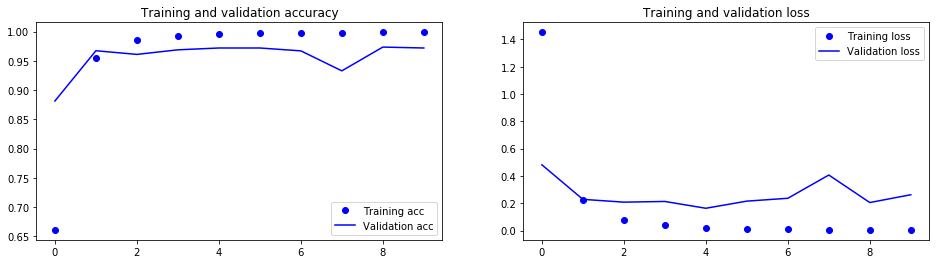

Training took a total of 0:08:13.971530


In [93]:
import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_relu_1_history = fit_model(model_relu_1, plot=True)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

In [244]:
evaluate_model_on_test(model_relu_1, test_generator)

Generated 6999 predictions
Test Acc: 0.9672810401485926
Test Loss: 0.2376485029854422
Confusion Matrix
[[  4 160   0 ...   0   0   0]
 [  0   4 143 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...  86 160   0]
 [  0   0   0 ...   0   4 160]
 [160   0   0 ...   0   0  89]]


In [245]:
models_list.append(('model_relu_1', 'relu', 'RMSprop', 1, 'valid', False, 0, 10, 0.0050, 0.9988, 0.2625, 0.9719, 0.967, 0.237 ))

#### tanh, RMSprop, 1 layer, 10 epochs

Epoch 1/10
522/522 [==============================] - 52s 99ms/step - loss: 0.9499 - acc: 0.8251 - val_loss: 0.3714 - val_acc: 0.9547
Epoch 2/10
522/522 [==============================] - 56s 106ms/step - loss: 0.1364 - acc: 0.9932 - val_loss: 0.1573 - val_acc: 0.9766
Epoch 3/10
522/522 [==============================] - 52s 100ms/step - loss: 0.0344 - acc: 0.9992 - val_loss: 0.1821 - val_acc: 0.9607
Epoch 4/10
522/522 [==============================] - 49s 94ms/step - loss: 0.0093 - acc: 0.9999 - val_loss: 0.2084 - val_acc: 0.9625
Epoch 5/10
522/522 [==============================] - 49s 94ms/step - loss: 0.0033 - acc: 0.9998 - val_loss: 0.1406 - val_acc: 0.9656
Epoch 6/10
522/522 [==============================] - 49s 94ms/step - loss: 0.0013 - acc: 0.9999 - val_loss: 0.1448 - val_acc: 0.9672
Epoch 7/10
522/522 [==============================] - 47s 90ms/step - loss: 5.2759e-04 - acc: 0.9999 - val_loss: 0.1405 - val_acc: 0.9766
Epoch 8/10
522/522 [==============================] - 46

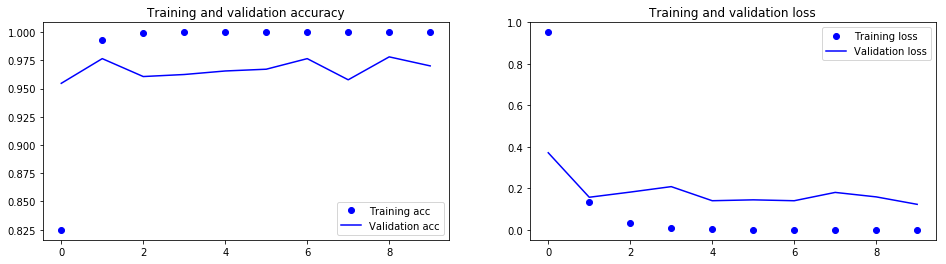

Training took a total of 0:08:16.932810


In [95]:
import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_tanh_1_history = fit_model(model_tanh_1, plot=True)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

In [246]:
evaluate_model_on_test(model_tanh_1, test_generator)

Generated 6999 predictions
Test Acc: 0.9694242034576368
Test Loss: 0.1758440404339125
Confusion Matrix
[[  0 104  60 ...   0   0   0]
 [  0   0  83 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...  22 164  60]
 [  0   0   0 ...   0   0 164]
 [164  60   0 ...   0   0  25]]


In [248]:
models_list.append(('model_tanh_1', 'tanh', 'RMSprop', 1, 'valid', False, 0, 10, 0.00009, 0.999, 0.1232, 0.9701, 0.1758, 0.9694))

#### relu, RMSprop, 2 layers, 10 epochs

Epoch 1/10
522/522 [==============================] - 65s 124ms/step - loss: 1.2886 - acc: 0.6835 - val_loss: 0.3643 - val_acc: 0.9469
Epoch 2/10
522/522 [==============================] - 61s 116ms/step - loss: 0.1432 - acc: 0.9665 - val_loss: 0.1446 - val_acc: 0.9641
Epoch 3/10
522/522 [==============================] - 63s 120ms/step - loss: 0.0476 - acc: 0.9898 - val_loss: 0.1665 - val_acc: 0.9578
Epoch 4/10
522/522 [==============================] - 65s 125ms/step - loss: 0.0233 - acc: 0.9951 - val_loss: 0.1975 - val_acc: 0.9703
Epoch 5/10
522/522 [==============================] - 64s 122ms/step - loss: 0.0118 - acc: 0.9971 - val_loss: 0.3071 - val_acc: 0.9547
Epoch 6/10
522/522 [==============================] - 62s 119ms/step - loss: 0.0081 - acc: 0.9980 - val_loss: 0.3004 - val_acc: 0.9638
Epoch 7/10
522/522 [==============================] - 63s 121ms/step - loss: 0.0070 - acc: 0.9978 - val_loss: 0.2031 - val_acc: 0.9719
Epoch 8/10
522/522 [==============================] - 6

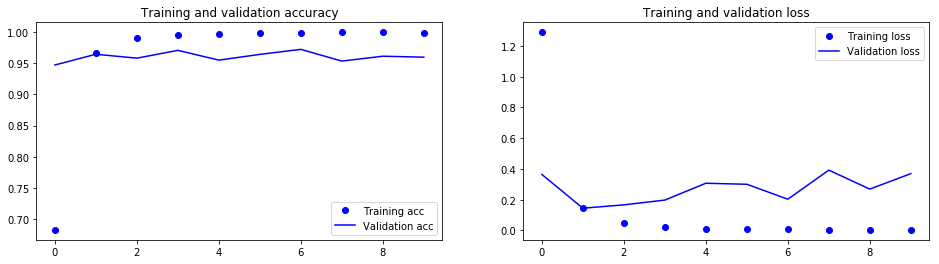

Training took a total of 0:10:31.205773


In [97]:
import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_relu_2_history = fit_model(model_relu_2, plot=True)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))


In [249]:
evaluate_model_on_test(model_relu_2, test_generator)

Generated 6999 predictions
Test Acc: 0.9635662237462495
Test Loss: 0.19488023300696775
Confusion Matrix
[[  0  40 124 ...   0   0   0]
 [  0   0  19 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0 122 124]
 [ 39   0   0 ...   0   0 125]
 [ 95 124   0 ...   0   0   0]]


In [250]:
models_list.append(('model_relu_2', 'relu', 'RMSprop', 2, 'valid', False, 0, 10, 0.0039, 0.9989, 0.3695, 0.9594, 0.1948, 0.9635))

#### tanh, RMSprop, 2 layers, 10 epochs

Epoch 1/10
522/522 [==============================] - 56s 107ms/step - loss: 0.9748 - acc: 0.8352 - val_loss: 0.3024 - val_acc: 0.9812
Epoch 2/10
522/522 [==============================] - 53s 102ms/step - loss: 0.1253 - acc: 0.9946 - val_loss: 0.1373 - val_acc: 0.9750
Epoch 3/10
522/522 [==============================] - 53s 102ms/step - loss: 0.0301 - acc: 0.9995 - val_loss: 0.1540 - val_acc: 0.9748
Epoch 4/10
522/522 [==============================] - 53s 102ms/step - loss: 0.0078 - acc: 0.9998 - val_loss: 0.1007 - val_acc: 0.9828
Epoch 5/10
522/522 [==============================] - 55s 105ms/step - loss: 0.0023 - acc: 0.9999 - val_loss: 0.1002 - val_acc: 0.9859
Epoch 6/10
522/522 [==============================] - 64s 123ms/step - loss: 7.4220e-04 - acc: 0.9999 - val_loss: 0.0901 - val_acc: 0.9891
Epoch 7/10
522/522 [==============================] - 65s 124ms/step - loss: 2.4514e-04 - acc: 0.9999 - val_loss: 0.0457 - val_acc: 0.9938
Epoch 8/10
522/522 [===========================

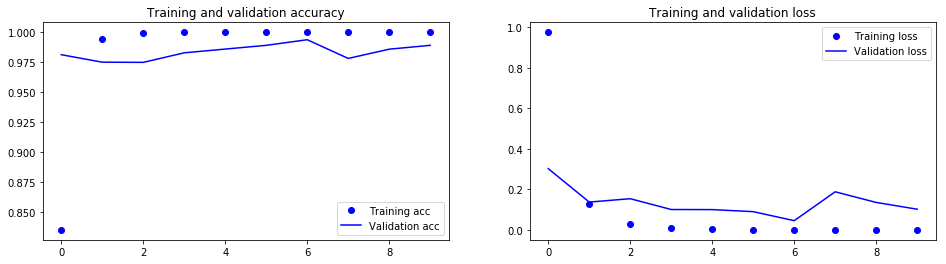

Training took a total of 0:09:35.952748


In [106]:
import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_tanh_2_history = fit_model(model_tanh_2, plot=True)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))


In [251]:
evaluate_model_on_test(model_tanh_2, test_generator)

Generated 6999 predictions
Test Acc: 0.9852836119445635
Test Loss: 0.10263347271645912
Confusion Matrix
[[  0   0  87 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0  26 220]
 [135   0   0 ...   0   0  29]
 [ 28 164  56 ...   0   0   0]]


In [252]:
models_list.append(('model_tanh_2', 'tanh', 'RMSprop', 2, 'valid', False, 0, 10, 0.00003, 0.999, 0.1022, 0.9891, 0.1026, 0.985))

#### relu, RMSprop, 3 layers, 5 epochs

Epoch 1/5
522/522 [==============================] - 61s 117ms/step - loss: 1.2815 - acc: 0.6883 - val_loss: 0.5129 - val_acc: 0.8969
Epoch 2/5
522/522 [==============================] - 62s 119ms/step - loss: 0.1439 - acc: 0.9611 - val_loss: 0.2925 - val_acc: 0.9531
Epoch 3/5
522/522 [==============================] - 71s 135ms/step - loss: 0.0509 - acc: 0.9861 - val_loss: 0.2750 - val_acc: 0.9422
Epoch 4/5
522/522 [==============================] - 78s 150ms/step - loss: 0.0251 - acc: 0.9938 - val_loss: 0.3707 - val_acc: 0.9547
Epoch 5/5
522/522 [==============================] - 92s 177ms/step - loss: 0.0144 - acc: 0.9966 - val_loss: 0.2675 - val_acc: 0.9764


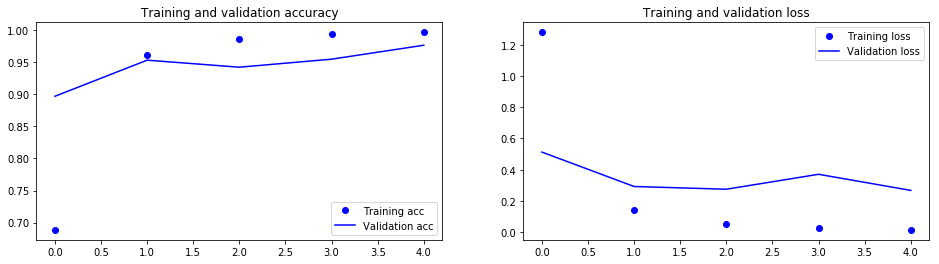

Training took a total of 0:06:05.048291


In [108]:
import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_relu_3_history = fit_model(model_relu_3, epochs=5, plot=True)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))


In [253]:
evaluate_model_on_test(model_relu_3, test_generator)

Generated 6999 predictions
Test Acc: 0.9649949992856123
Test Loss: 0.2547167492495704
Confusion Matrix
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [ 67   0   0 ...   0   0 179]
 [ 86  67   0 ...   0   0   0]
 [  0  97 143 ...   0   0   0]]


In [254]:
models_list.append(('model_relu_3', 'relu', 'RMSprop', 3, 'valid', False, 0, 5, 0.0144, 0.9966, 0.2675, 0.9764, 0.2547, 0.964))

## Models Using Dropout

#### relu, RMSprop, 2 layers, 50 epochs, dropout 50%

Epoch 1/50
100/100 [==============================] - 13s 130ms/step - loss: 3.6091 - acc: 0.0634 - val_loss: 3.5305 - val_acc: 0.2313
Epoch 2/50
100/100 [==============================] - 12s 116ms/step - loss: 3.2832 - acc: 0.1497 - val_loss: 3.1585 - val_acc: 0.2516
Epoch 3/50
100/100 [==============================] - 12s 119ms/step - loss: 2.8306 - acc: 0.2309 - val_loss: 2.6598 - val_acc: 0.4781
Epoch 4/50
100/100 [==============================] - 12s 115ms/step - loss: 2.4549 - acc: 0.3056 - val_loss: 2.2101 - val_acc: 0.5891
Epoch 5/50
100/100 [==============================] - 12s 118ms/step - loss: 2.1351 - acc: 0.3769 - val_loss: 1.8065 - val_acc: 0.7421
Epoch 6/50
100/100 [==============================] - 12s 117ms/step - loss: 1.9407 - acc: 0.4247 - val_loss: 1.5473 - val_acc: 0.7719
Epoch 7/50
100/100 [==============================] - 12s 117ms/step - loss: 1.6864 - acc: 0.4897 - val_loss: 1.2391 - val_acc: 0.8250
Epoch 8/50
100/100 [==============================] - 1

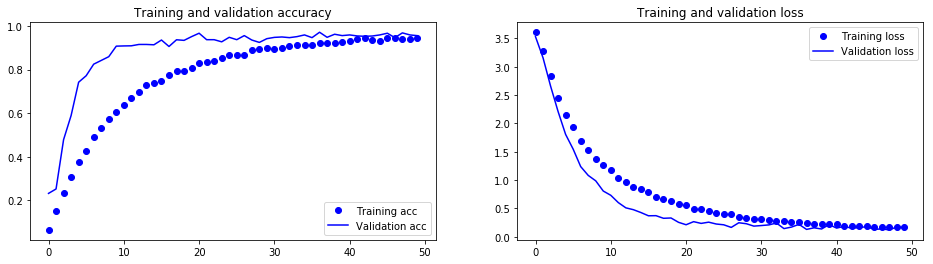

Training took a total of 0:10:05.083345
Generated 6999 predictions
Test Acc: 0.9438491213030433
Confusion Matrix
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [ 31 164  27 ...   0   0   0]
 [  0   0 116 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [117]:
model_relu_2_dropout_50 = model_2_layer(dropout=True, dropout_rate=0.5)

import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_relu_2_dropout_50_history = fit_model(model_relu_2_dropout_50, epochs=50, plot=True, steps_per_epoch=100)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))



In [255]:
evaluate_model_on_test(model_relu_2_dropout_50, test_generator)

Generated 6999 predictions
Test Acc: 0.9438491213030433
Test Loss: 0.18834200030457754
Confusion Matrix
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [126   0   0 ...   0   0 115]
 [ 14 131   0 ...   0   0   0]
 [  0  33 143 ...   0   0   0]]


In [256]:
models_list.append(('model_relu_2_dropout_50', 'relu', 'RMSprop', 2, 'valid', True, 0.50, 50, 0.1691, 0.9441, 0.1570, 0.9560, 0.1883, 0.943))

#### tanh, RMSprop, 2 layers, 50 epochs, dropout 50%

Epoch 1/10
100/100 [==============================] - 14s 142ms/step - loss: 3.2726 - acc: 0.1519 - val_loss: 2.8199 - val_acc: 0.2704
Epoch 2/10
100/100 [==============================] - 12s 122ms/step - loss: 2.4780 - acc: 0.3403 - val_loss: 2.2560 - val_acc: 0.4031
Epoch 3/10
100/100 [==============================] - 12s 124ms/step - loss: 1.9631 - acc: 0.4791 - val_loss: 1.6778 - val_acc: 0.6453
Epoch 4/10
100/100 [==============================] - 12s 122ms/step - loss: 1.5623 - acc: 0.6125 - val_loss: 1.3936 - val_acc: 0.7266
Epoch 5/10
100/100 [==============================] - 12s 122ms/step - loss: 1.2632 - acc: 0.6906 - val_loss: 1.1089 - val_acc: 0.8594
Epoch 6/10
100/100 [==============================] - 12s 120ms/step - loss: 1.0422 - acc: 0.7556 - val_loss: 0.9536 - val_acc: 0.8922
Epoch 7/10
100/100 [==============================] - 12s 124ms/step - loss: 0.8496 - acc: 0.8119 - val_loss: 0.8289 - val_acc: 0.8688
Epoch 8/10
100/100 [==============================] - 1

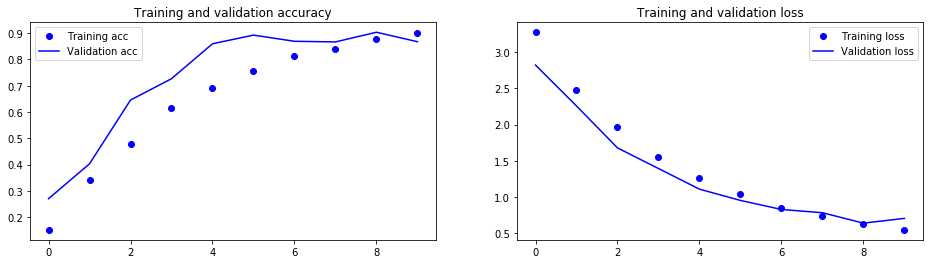

Training took a total of 0:02:05.962678


In [161]:
# model_relu_1_dropout = model_1_layer(dropout=True)
# model_relu_2_dropout = model_2_layer(dropout=True)
# model_relu_3_dropout = model_3_layer(dropout=True)

model_tanh_2_dropout_50 = model_2_layer(activation='tanh', dropout=True, dropout_rate=0.5)

import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_tanh_2_dropout_50_history = fit_model(model_tanh_2_dropout_50, epochs=10, plot=True, steps_per_epoch=100)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))



In [257]:
evaluate_model_on_test(model_tanh_2_dropout_50, test_generator)

Generated 6999 predictions
Test Acc: 0.8299757108158309
Test Loss: 0.8069069898579654
Confusion Matrix
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [127   0   0 ...   0   0  19]
 [  0  32  63 ...   0   0   0]
 [  0   0  77 ...   0   0   0]]


Confusion matrix, without normalization
[[127   0   0 ...   0   0   0]
 [  0  32   0 ...   0   0   0]
 [  0   0 140 ...   0   0   0]
 ...
 [  0   0   0 ... 246   0   0]
 [  0   0   0 ...   0 164   0]
 [  0   0   0 ...   0   0 249]]


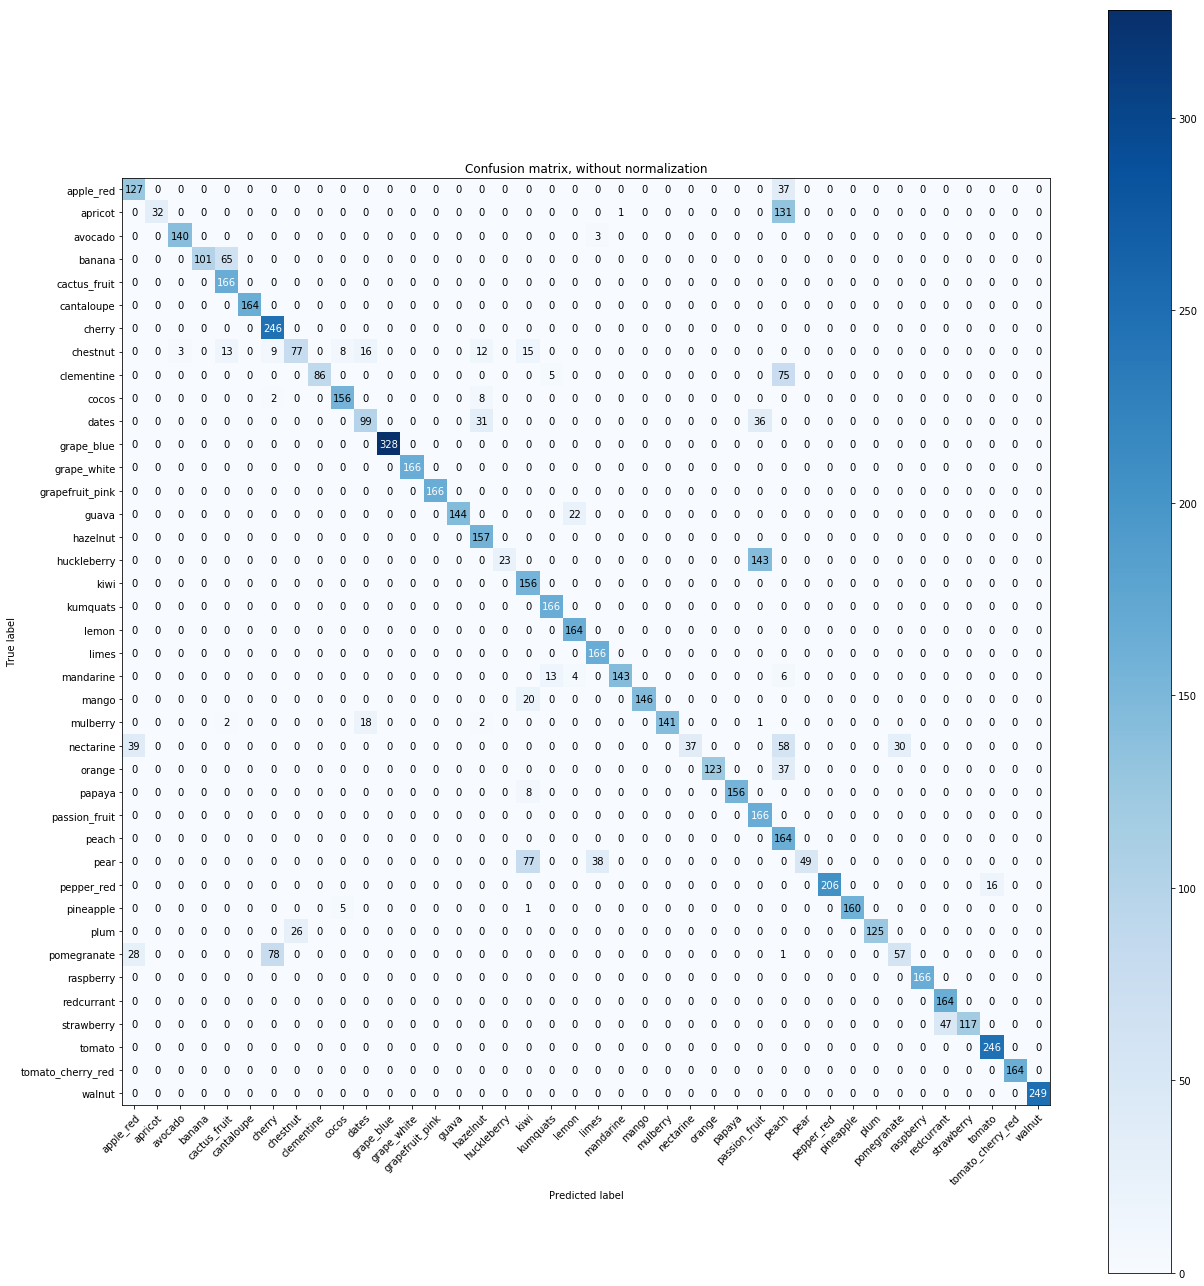

In [261]:
test_generator.reset()
Y_pred = model_tanh_2_dropout_50.predict_generator(test_generator, steps=len(test_generator))
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)

plot_confusion_matrix(test_generator.classes[test_generator.index_array], y_pred, classes=class_names)

In [258]:
models_list.append(('model_tanh_2_dropout_50', 'tanh', 'RMSprop', 2, 'valid', True, 0.50, 10, 0.547, 0.8988, 0.7060, 0.8672, 0.806, 0.8299))

## Slightly Improved Models

### 3 Layer, Relu, Dropout=0.30, 10 epochs, optimizers=RMSprop/Adam

In [266]:
model_relu_adam = Sequential()
model_relu_adam.add(Conv2D(32,(3,3), padding='same', activation='relu', input_shape=(64,64,3)))
model_relu_adam.add(MaxPooling2D((2,2)))
model_relu_adam.add(Dropout(0.30))
model_relu_adam.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model_relu_adam.add(MaxPooling2D((2,2)))
model_relu_adam.add(Dropout(0.30))
model_relu_adam.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model_relu_adam.add(MaxPooling2D((2,2)))
model_relu_adam.add(Dropout(0.30))
model_relu_adam.add(Flatten())
model_relu_adam.add(Dense(128, activation='relu'))
model_relu_adam.add(Dropout(0.30))
model_relu_adam.add(Dense(40, activation='softmax'))
model_relu_adam.compile(loss='categorical_crossentropy',
                       optimizer=adam(lr=0.001, decay=1e-6),
                       metrics=['acc'])
model_relu_adam.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 16, 16, 128)       73856     
__________

Epoch 1/10
100/100 [==============================] - 19s 189ms/step - loss: 2.9497 - acc: 0.1694 - val_loss: 1.5979 - val_acc: 0.5953
Epoch 2/10
100/100 [==============================] - 17s 174ms/step - loss: 1.0347 - acc: 0.6616 - val_loss: 0.3744 - val_acc: 0.9125
Epoch 3/10
100/100 [==============================] - 17s 175ms/step - loss: 0.5045 - acc: 0.8244 - val_loss: 0.2260 - val_acc: 0.9484
Epoch 4/10
100/100 [==============================] - 17s 175ms/step - loss: 0.2890 - acc: 0.8984 - val_loss: 0.2345 - val_acc: 0.9481
Epoch 5/10
100/100 [==============================] - 18s 176ms/step - loss: 0.2159 - acc: 0.9275 - val_loss: 0.2330 - val_acc: 0.9719
Epoch 6/10
100/100 [==============================] - 17s 174ms/step - loss: 0.2332 - acc: 0.9200 - val_loss: 0.0825 - val_acc: 0.9719
Epoch 7/10
100/100 [==============================] - 17s 174ms/step - loss: 0.1581 - acc: 0.9437 - val_loss: 0.1879 - val_acc: 0.9516
Epoch 8/10
100/100 [==============================] - 1

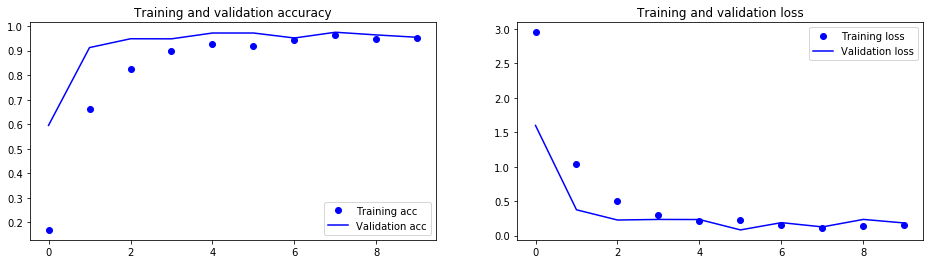

Training took a total of 0:02:57.023944


In [267]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_relu_adam_history = fit_model(model_relu_adam, epochs=10, plot=True, steps_per_epoch=100)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

In [269]:
evaluate_model_on_test(model_relu_adam, test_generator)

Generated 6999 predictions
Test Acc: 0.9661380197171024
Test Loss: 0.18421929204259446
Confusion Matrix
[[  4 160   0 ...   0   0   0]
 [  0   4 143 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...  86 160   0]
 [  0   0   0 ...   0   4 160]
 [158   0   0 ...   0   0  89]]


Confusion matrix, without normalization
[[162   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 143 ...   0   0   0]
 ...
 [  0   0   0 ... 246   0   0]
 [  0   0   0 ...   0 164   0]
 [  0   0   0 ...   0   0 249]]


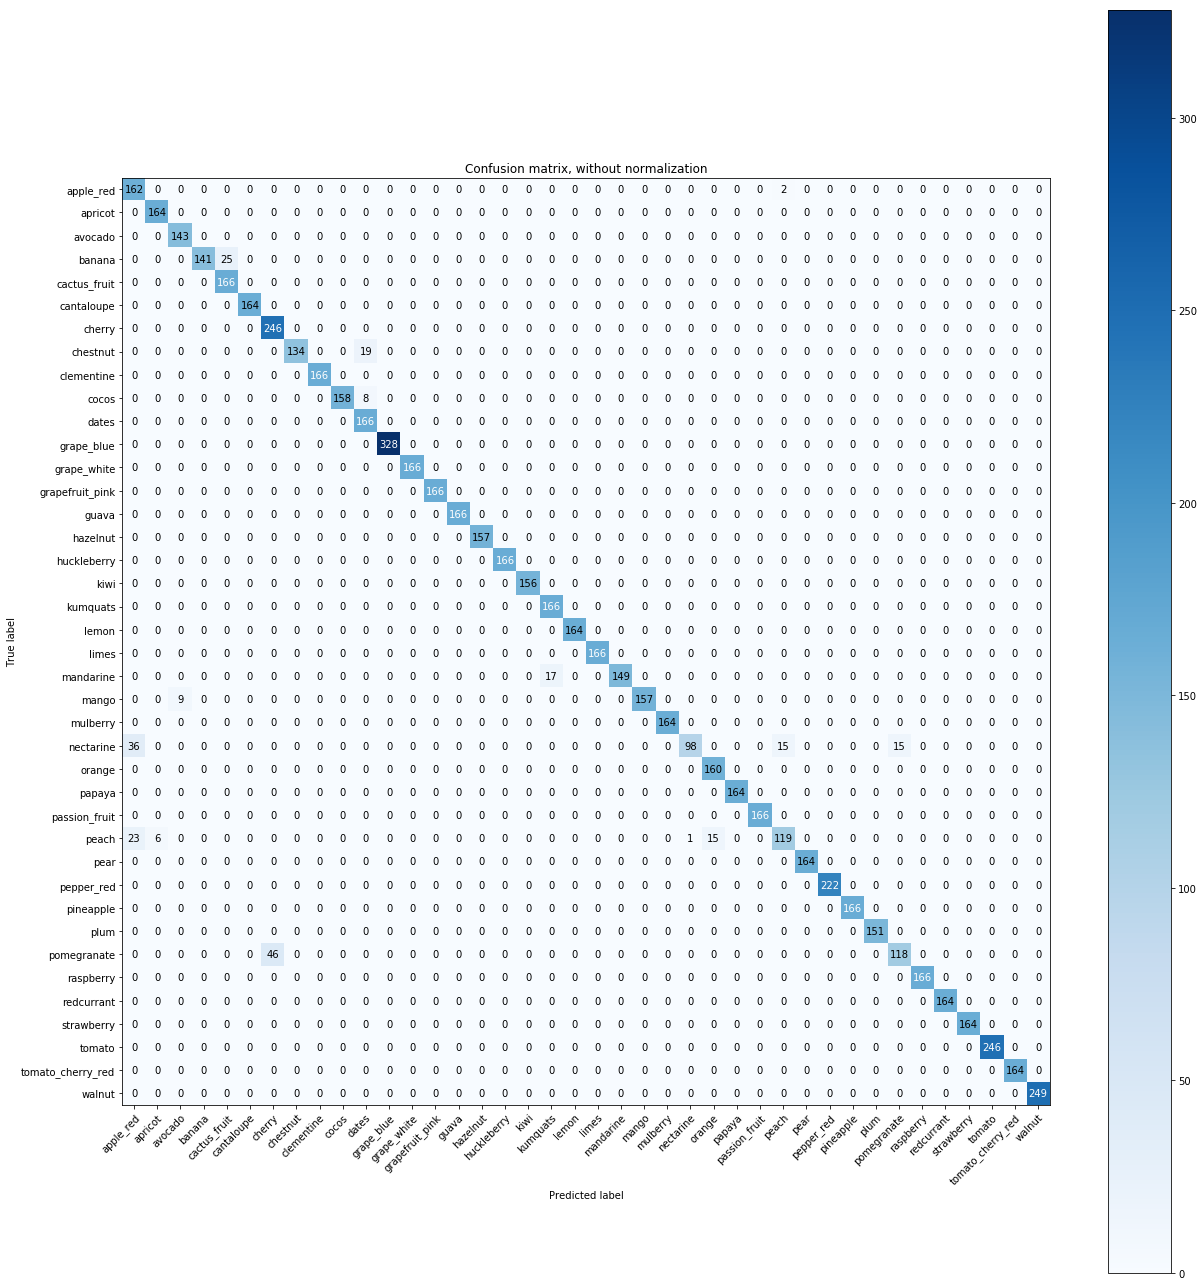

In [270]:
test_generator.reset()
Y_pred = model_relu_adam.predict_generator(test_generator, steps=len(test_generator))
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)

plot_confusion_matrix(test_generator.classes[test_generator.index_array], y_pred, classes=class_names)

In [271]:
models_list.append(('model_relu_adam', 'relu', 'adam', 3, 'same', True, 0.30, 10, 0.1585,0.9503, 0.1830, 0.9544, 0.1842,0.966))

### 3 Layer, tanh, Dropout=0.30, 10 epochs, optimizer=Adam

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 16, 16, 128)       73856     
__________

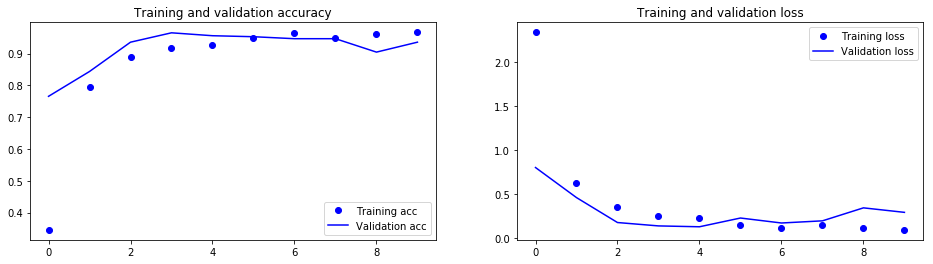

Training took a total of 0:03:08.841154


In [283]:
model_tanh_adam = Sequential()
model_tanh_adam.add(Conv2D(32,(3,3), padding='same', activation='tanh', input_shape=(64,64,3)))
model_tanh_adam.add(MaxPooling2D((2,2)))
model_tanh_adam.add(Dropout(0.30))
model_tanh_adam.add(Conv2D(64,(3,3), padding='same', activation='tanh'))
model_tanh_adam.add(MaxPooling2D((2,2)))
model_tanh_adam.add(Dropout(0.30))
model_tanh_adam.add(Conv2D(128, (3,3), padding='same', activation='tanh'))
model_tanh_adam.add(MaxPooling2D((2,2)))
model_tanh_adam.add(Dropout(0.30))
model_tanh_adam.add(Flatten())
model_tanh_adam.add(Dense(128, activation='relu'))
model_tanh_adam.add(Dropout(0.30))
model_tanh_adam.add(Dense(40, activation='softmax'))
model_tanh_adam.compile(loss='categorical_crossentropy',
                       optimizer=adam(lr=0.001, decay=1e-6),
                       metrics=['acc'])
model_relu_adam.summary()

original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_tanh_adam_history = fit_model(model_tanh_adam, epochs=10, plot=True, steps_per_epoch=100)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

In [284]:
evaluate_model_on_test(model_tanh_adam, test_generator)

Generated 6999 predictions
Test Acc: 0.9154164880697242
Test Loss: 0.3618965539145534
Confusion Matrix
[[  0 136  28 ...   0   0   0]
 [  0   0 115 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...  54 164  28]
 [  0   0   0 ...   0   0 164]
 [117  28   0 ...   0   0  57]]


Confusion matrix, without normalization
[[117   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 143 ...   0   0   0]
 ...
 [  0   0   0 ... 246   0   0]
 [  0   0   0 ...   0 164   0]
 [  0   0   0 ...   0   0 249]]


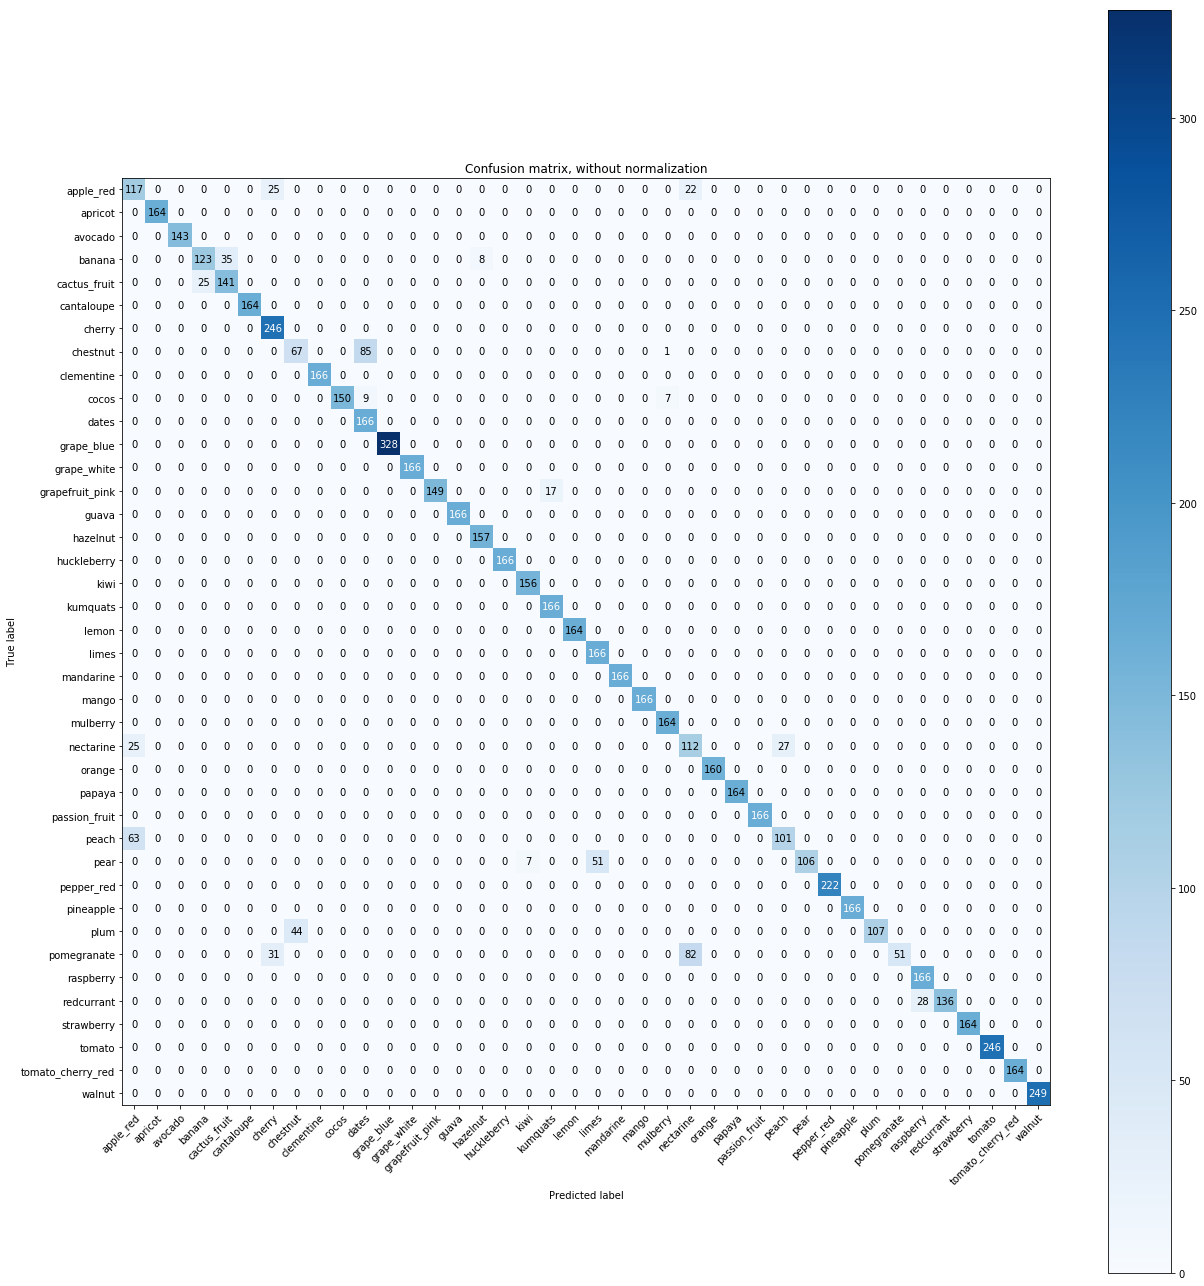

In [285]:
test_generator.reset()
Y_pred = model_tanh_adam.predict_generator(test_generator, steps=len(test_generator))
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)

plot_confusion_matrix(test_generator.classes[test_generator.index_array], y_pred, classes=class_names)

In [290]:
models_list.append(('model_tanh_adam', 'tanh', 'adam', 3, 'same', True, 0.30, 10, 0.0926, 0.9672, 0.2918, 0.9359, 0.3618, 0.915))

# Modeling - V1 - Recap

In [308]:
models_df = pd.DataFrame(models_list, columns = model_columns)
models_df

,model_name,activation,optimizer,layers,padding,dropout,dropout_rate,epochs,train_loss,train_acc,val_loss,val_acc,test_loss,test_acc
0,model_relu_1,relu,RMSprop,1,valid,False,0.0,10,0.00500,0.9988,0.2625,0.9719,0.9670,0.2370
1,model_tanh_1,tanh,RMSprop,1,valid,False,0.0,10,0.00009,0.9990,0.1232,0.9701,0.1758,0.9694
2,model_relu_2,relu,RMSprop,2,valid,False,0.0,10,0.00390,0.9989,0.3695,0.9594,0.1948,0.9635
3,model_tanh_2,tanh,RMSprop,2,valid,False,0.0,10,0.00003,0.9990,0.1022,0.9891,0.1026,0.9850
4,model_relu_3,relu,RMSprop,3,valid,False,0.0,5,0.01440,0.9966,0.2675,0.9764,0.2547,0.9640
5,model_relu_2_dropout_50,relu,RMSprop,2,valid,True,0.5,50,0.16910,0.9441,0.1570,0.9560,0.1883,0.9430
6,model_tanh_2_dropout_50,tanh,RMSprop,2,valid,True,0.5,10,0.54700,0.8988,0.7060,0.8672,0.8060,0.8299
7,model_relu_adam,relu,adam,3,same,True,0.3,10,0.15850,0.9503,0.1830,0.9544,0.1842,0.9660
8,model_tanh_adam,tanh,adam,3,same,True,0.3,10,0.09260,0.9672,0.2918,0.9359,0.3618,0.9150


### Initial Model Recap Takeaways

- Dropout layers are critical to protect against overfitting. The first five models had very low training loss, very high training accuracy, but the validation loss/accuracy diverged.  
- adam looks to perform better than RMSprop
- prefer padding same vs. valid given image types
- consider adding a 4th layer

# Modeling - V2

## Model_01

### Model_01 Parameters

- Optimizer: Adam
- Activation: relu
- Padding: same
- Layers: 4
- Dropout Rate: 0.3
- Epochs: 20
- Steps Per Epoch: 50

### Model Instantiation

In [330]:
model_01 = Sequential()
model_01.add(Conv2D(32,(3,3), padding='same', activation='relu', input_shape=(64,64,3)))
model_01.add(MaxPooling2D((2,2)))
model_01.add(Dropout(0.30))
model_01.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model_01.add(MaxPooling2D((2,2)))
model_01.add(Dropout(0.30))
model_01.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model_01.add(MaxPooling2D((2,2)))
model_01.add(Dropout(0.30))
model_01.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model_01.add(MaxPooling2D((2,2)))
model_01.add(Dropout(0.30))
model_01.add(Flatten())
model_01.add(Dropout(0.30))
model_01.add(Dense(512, activation='relu'))
model_01.add(Dense(40, activation='softmax'))
model_01.compile(loss='categorical_crossentropy',
                       optimizer=adam(lr=0.001, decay=1e-6),
                       metrics=['acc'])
model_01.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_162 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_106 (Dropout)        (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_161 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_107 (Dropout)        (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 16, 16, 128)       73856     
__________

### Model Fit

TRAIN LOSS:  0.05655335521325469
TRAIN ACC:  0.98
VAL LOSS:  0.10329525566194206
VAL ACC:  0.9859375


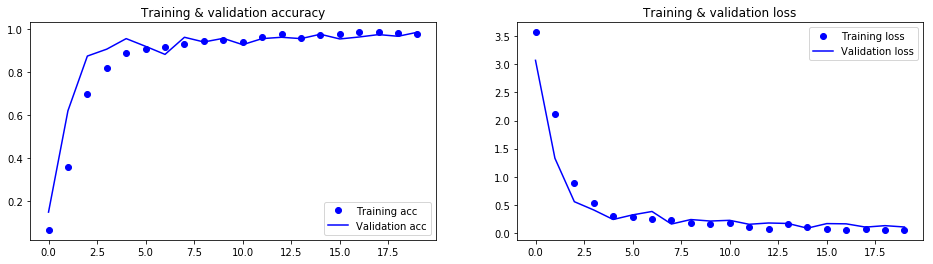

Training took a total of 0:05:08.425997


In [331]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_01_history = fit_model(model_01, epochs=20, plot=True, steps_per_epoch=50, verbose=0)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

### Evaluation On Test

In [332]:
evaluate_model_on_test(model_01, test_generator)

Generated 6999 predictions
Test Acc: 0.9719959994284898
Test Loss: 0.10166679193110745


### Confusion Matrix

Confusion matrix, without normalization


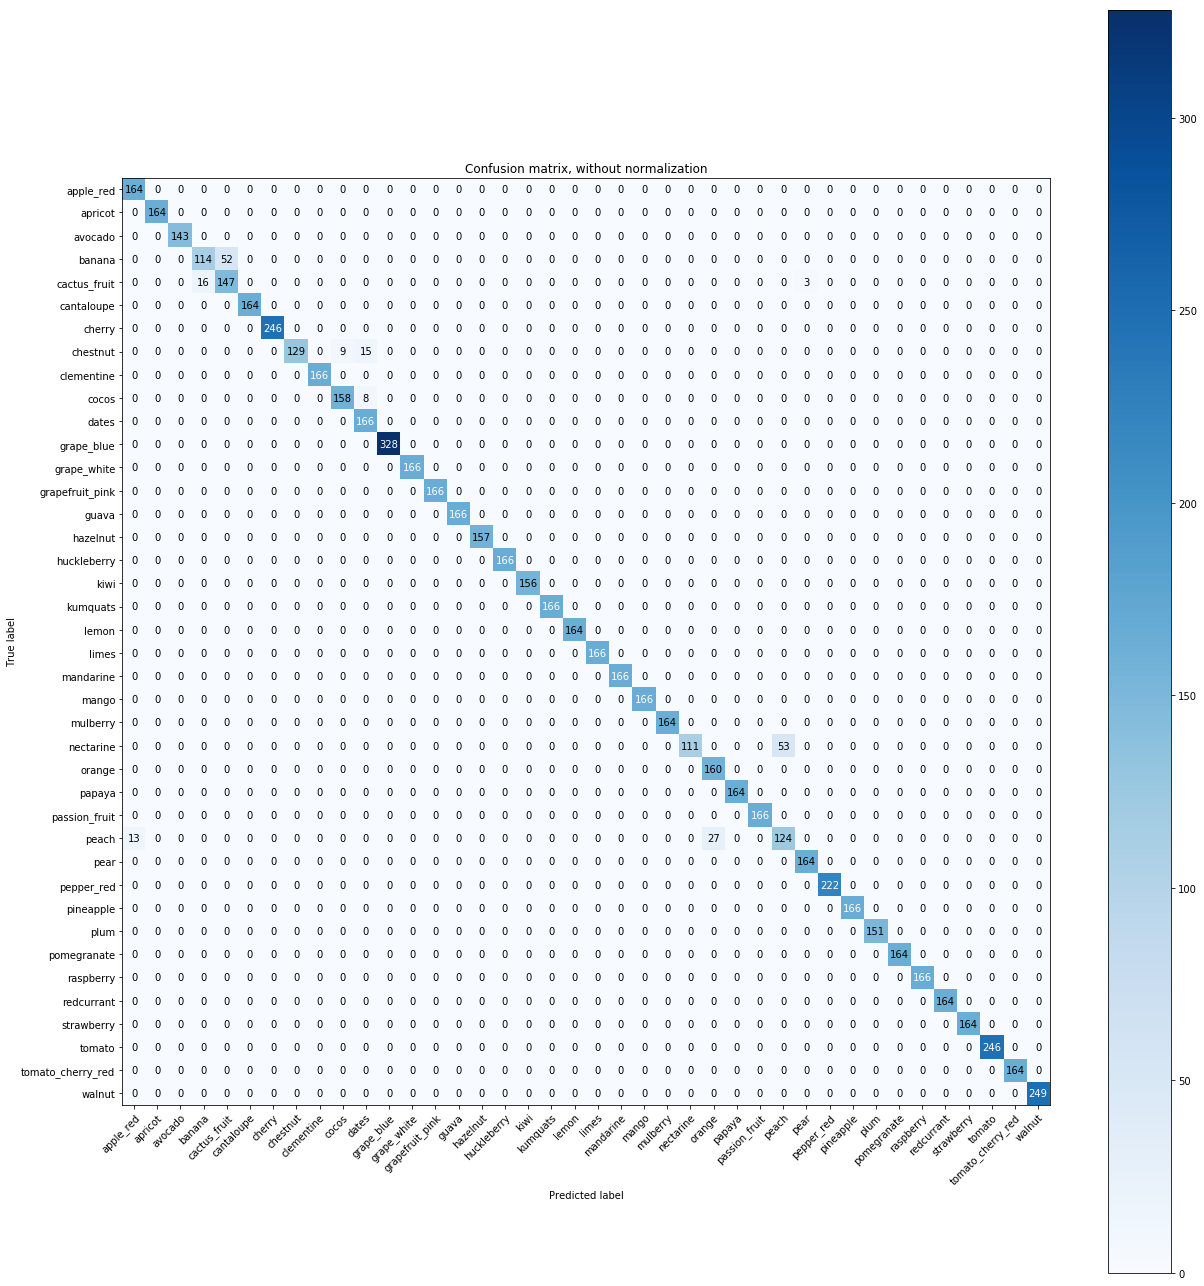

In [333]:
test_generator.reset()
Y_pred = model_01.predict_generator(test_generator, steps=len(test_generator))
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)

plot_confusion_matrix(test_generator.classes[test_generator.index_array], y_pred, classes=class_names)

### Record Model

In [338]:
models_list_2 = []

In [339]:
models_list_2.append(('model_01', 'relu', 'adam', 4, 'same', True, 0.30, 20, 
                    0.05655, 0.98, 0.103295, 0.9859, 0.1016, 0.97199
                   ))

## Model_02

### Model_02 Parameters

- Optimizer: Adam
- Activation: relu
- Padding: same (for single layer)
- Layers: 4
- Dropout Rate: 0.30
- Epochs: 10

### Model Instantiation & Fit

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_154 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_152 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_96 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_153 (MaxPoolin (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_97 (Dropout)         (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 13, 13, 128)       73856     
__________

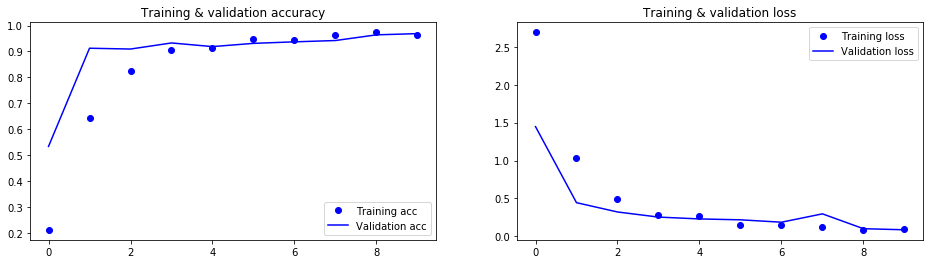

Training took a total of 0:03:09.931727


In [309]:
model_02 = Sequential()
model_02.add(Conv2D(32,(3,3), padding='same', activation='relu', input_shape=(64,64,3)))
model_02.add(MaxPooling2D((2,2)))
model_02.add(Dropout(0.30))
model_02.add(Conv2D(64,(3,3), activation='relu'))
model_02.add(MaxPooling2D((2,2)))
model_02.add(Dropout(0.30))
model_02.add(Conv2D(128, (3,3), activation='relu'))
model_02.add(MaxPooling2D((2,2)))
model_02.add(Dropout(0.30))
model_02.add(Conv2D(256, (3,3), activation='relu'))
model_02.add(MaxPooling2D((2,2)))
model_02.add(Dropout(0.30))
model_02.add(Flatten())
model_02.add(Dropout(0.30))
model_02.add(Dense(512, activation='relu'))
model_02.add(Dense(40, activation='softmax'))
model_02.compile(loss='categorical_crossentropy',
                       optimizer=adam(lr=0.001, decay=1e-6),
                       metrics=['acc'])
model_02.summary()

original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_02_history = fit_model(model_02, epochs=10, plot=True, steps_per_epoch=100)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

### Evaluation On Test

In [322]:
model_02_history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [310]:
evaluate_model_on_test(model_02, test_generator)

Generated 6999 predictions
Test Acc: 0.9457065295042149
Test Loss: 0.12304144031062987


### Confusion Matrix

Confusion matrix, without normalization


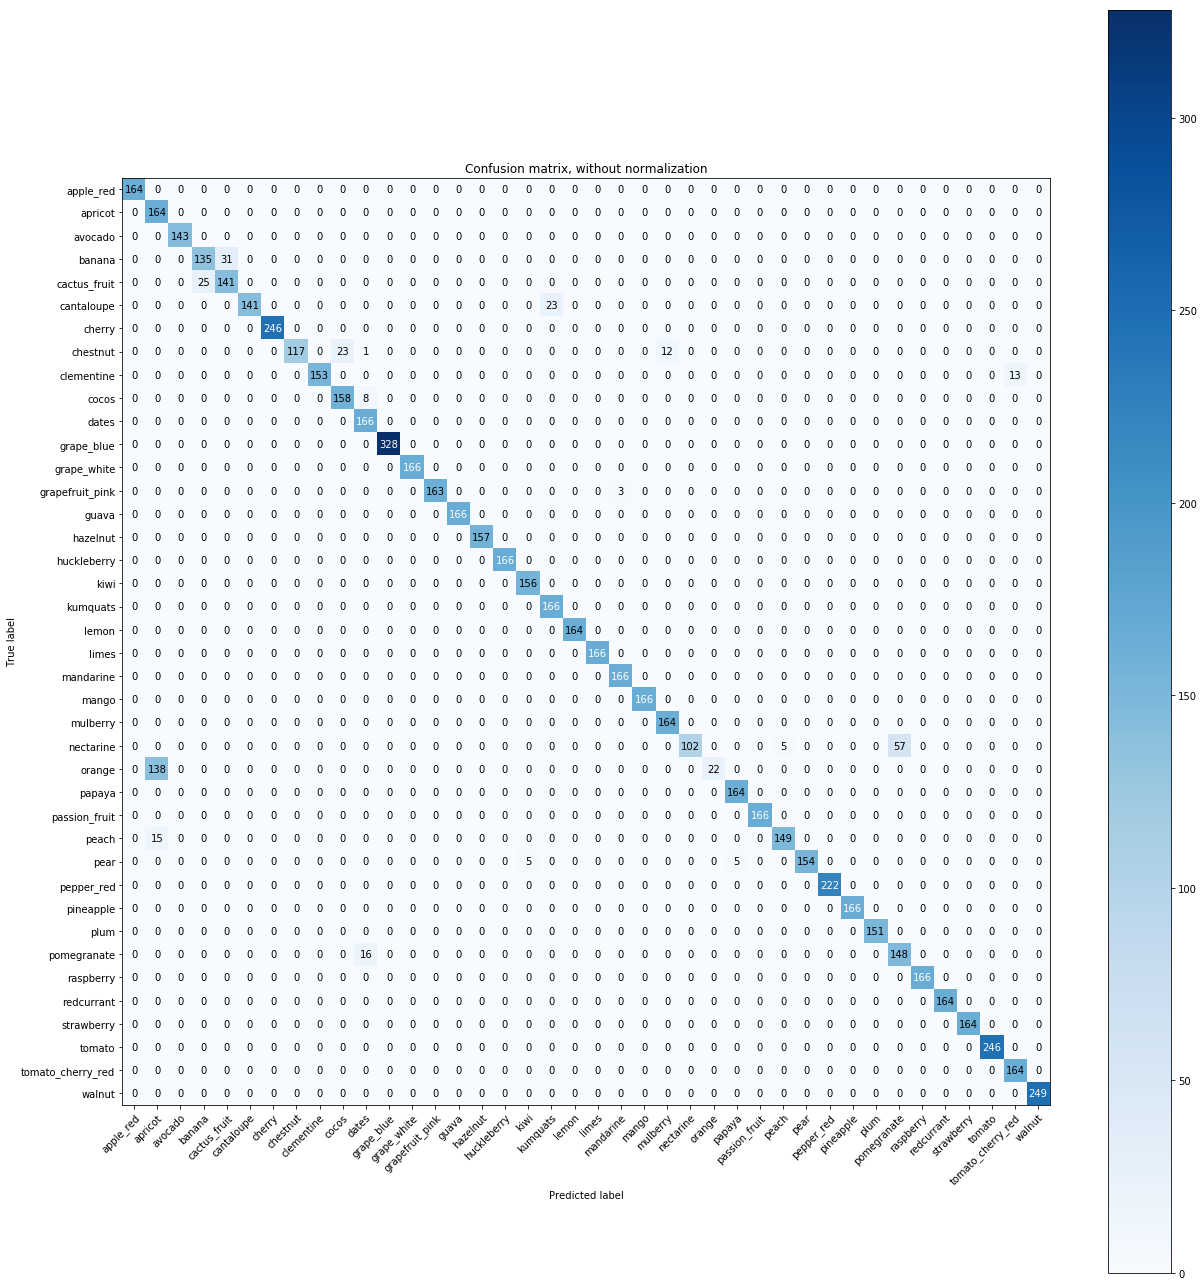

In [313]:
test_generator.reset()
Y_pred = model_02.predict_generator(test_generator, steps=len(test_generator))
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)

plot_confusion_matrix(test_generator.classes[test_generator.index_array], y_pred, classes=class_names)

### Record Model

In [340]:
models_list_2.append(('model_02', 'relu', 'adam', 4, 'same', True, 0.30, 10, 
                    0.1014, 0.9637, 0.0876, 0.9688, 0.1230, 0.9457
                   ))

## Model_03

### Model_03 Parameters

- Optimizer: RMSprop
- Activation: relu
- Padding: same
- Layers: 4
- Dropout Rate: 0.30
- Epochs: 20

### Model Instantiation

In [336]:
model_03 = Sequential()
model_03.add(Conv2D(32,(3,3), padding='same', activation='relu', input_shape=(64,64,3)))
model_03.add(MaxPooling2D((2,2)))
model_03.add(Dropout(0.30))
model_03.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model_03.add(MaxPooling2D((2,2)))
model_03.add(Dropout(0.30))
model_03.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model_03.add(MaxPooling2D((2,2)))
model_03.add(Dropout(0.30))
model_03.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model_03.add(MaxPooling2D((2,2)))
model_03.add(Dropout(0.30))
model_03.add(Flatten())
model_03.add(Dropout(0.30))
model_03.add(Dense(512, activation='relu'))
model_03.add(Dense(40, activation='softmax'))
model_03.compile(loss='categorical_crossentropy',
                       optimizer=optimizers.RMSprop(lr=1e-4),
                       metrics=['acc'])
model_03.summary()

# optimizer=adam(lr=0.001, decay=1e-6),

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_166 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_111 (Dropout)        (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_112 (Dropout)        (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 16, 16, 128)       73856     
__________

### Model Fit

TRAIN LOSS:  0.38251767709851264
TRAIN ACC:  0.866875
VAL LOSS:  0.3824687346816063
VAL ACC:  0.89375


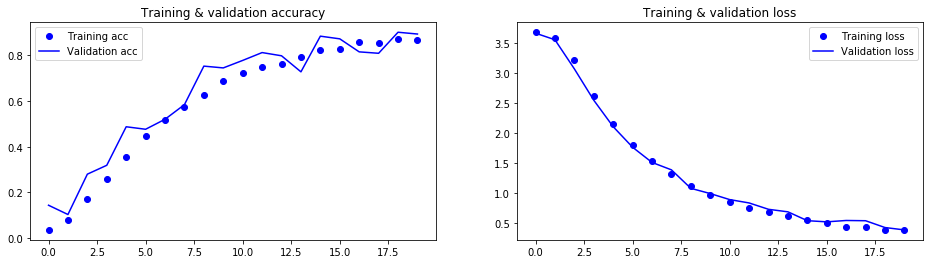

Training took a total of 0:04:27.536197


In [337]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_03_history = fit_model(model_03, epochs=20, plot=True, steps_per_epoch=50, verbose=0)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

### Evaluation On Test

In [341]:
evaluate_model_on_test(model_03, test_generator)

Generated 6999 predictions
Test Acc: 0.8676953850550079
Test Loss: 0.4926441290801313


### Confusion Matrix

Confusion matrix, without normalization


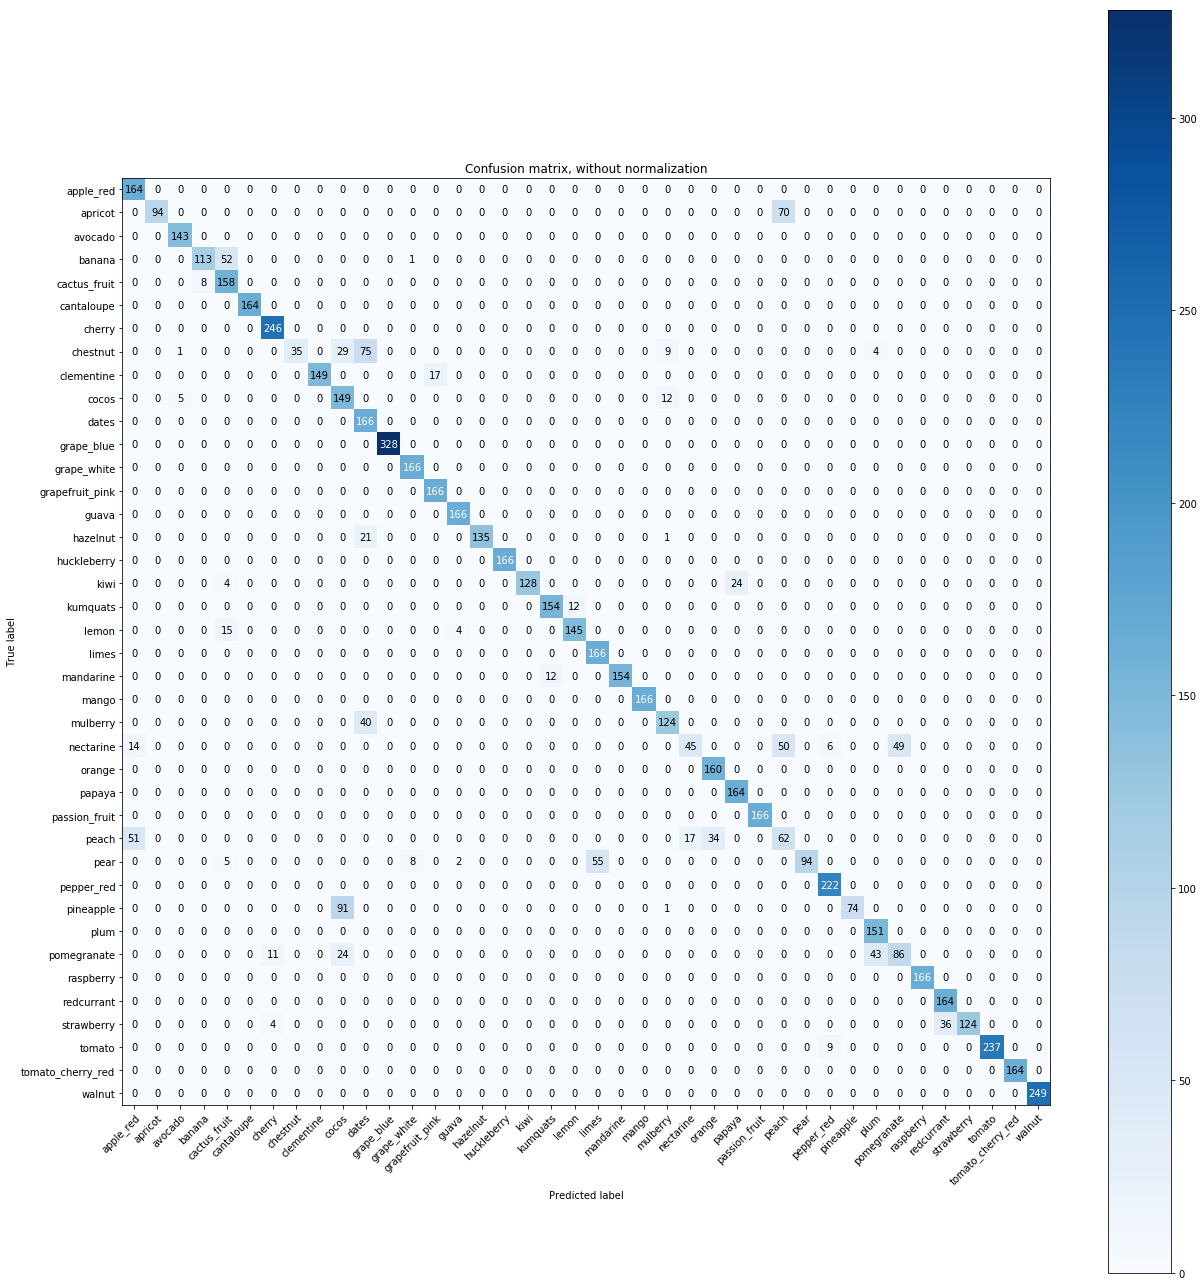

In [342]:
test_generator.reset()
Y_pred = model_03.predict_generator(test_generator, steps=len(test_generator))
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)

plot_confusion_matrix(test_generator.classes[test_generator.index_array], y_pred, classes=class_names)

### Record Model

In [343]:
models_list_2.append(
    ('model_03', 'relu', 'RMSprop', 4, 'same', True, 0.30, 20,
     0.3825, 0.8668, 0.38246, 0.89375, 0.4926, 0.8676
    )
)

## Model_04

### Model_04 Parameters

- Optimizer: Adam
- Activation: relu
- Padding: same
- Layers: 4
- Dropout Rate: 0.25
- Epochs: 30
- Steps Per Epoch: 50

### Model Instantiation

In [344]:
model_04 = Sequential()
model_04.add(Conv2D(32,(3,3), padding='same', activation='relu', input_shape=(64,64,3)))
model_04.add(MaxPooling2D((2,2)))
model_04.add(Dropout(0.25))
model_04.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model_04.add(MaxPooling2D((2,2)))
model_04.add(Dropout(0.25))
model_04.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model_04.add(MaxPooling2D((2,2)))
model_04.add(Dropout(0.25))
model_04.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model_04.add(MaxPooling2D((2,2)))
model_04.add(Dropout(0.25))
model_04.add(Flatten())
model_04.add(Dropout(0.25))
model_04.add(Dense(512, activation='relu'))
model_04.add(Dense(40, activation='softmax'))
model_04.compile(loss='categorical_crossentropy',
                       optimizer=adam(lr=0.001, decay=1e-6),
                       metrics=['acc'])
model_04.summary()

# optimizer=adam(lr=0.001, decay=1e-6),

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_170 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_168 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_116 (Dropout)        (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_169 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_117 (Dropout)        (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 16, 16, 128)       73856     
__________

### Model Fit

TRAIN LOSS:  0.00047397378071764254
TRAIN ACC:  1.0
VAL LOSS:  0.1465572265204173
VAL ACC:  0.9875


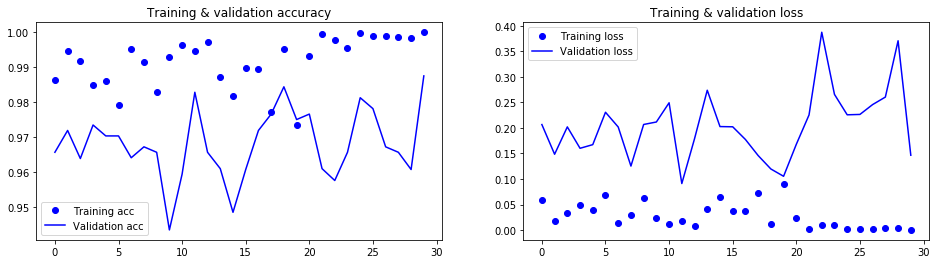

Training took a total of 0:11:53.731793


In [346]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_04_history = fit_model(model_04, epochs=30, plot=True, steps_per_epoch=100, verbose=0)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

### Evaluation On Test

In [347]:
evaluate_model_on_test(model_04, test_generator)

Generated 6999 predictions
Test Acc: 0.982997571081583
Test Loss: 0.1320598516342828


### Confusion Matrix

In [ ]:
test_generator.reset()
Y_pred = model_04.predict_generator(test_generator, steps=len(test_generator))
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)

plot_confusion_matrix(test_generator.classes[test_generator.index_array], y_pred, classes=class_names)

### Record Model

In [348]:
models_list_2.append(
    ('model_04', 'relu', 'Adam', 4, 'same', True, 0.25, 30,
     0.004, 0.999, 0.1465, 0.9875, 0.13205, 0.98299
    )
)

# Modeling V2 - Recap

In [349]:
models_df_2 = pd.DataFrame(models_list_2, columns = model_columns)
models_df_2

,model_name,activation,optimizer,layers,padding,dropout,dropout_rate,epochs,train_loss,train_acc,val_loss,val_acc,test_loss,test_acc
0,model_01,relu,adam,4,same,True,0.30,20,0.05655,0.9800,0.103295,0.98590,0.97199,0.10160
1,model_02,relu,adam,4,same,True,0.30,10,0.10140,0.9637,0.087600,0.96880,0.12300,0.94570
2,model_03,relu,RMSprop,4,same,True,0.30,20,0.38250,0.8668,0.382460,0.89375,0.49260,0.86760
3,model_04,relu,Adam,4,same,True,0.25,30,0.00400,0.9990,0.146500,0.98750,0.13205,0.98299


### Model Takeaways

A significant divergence between train loss and validation loss can signify overfitting, as in the last model (plus, the training accuracy was nearly 100, so definitely overfit).

- RMSprop again performed worse than Adam


This leaves model_01 and model_02 as the best models -- they are essentially the same, as they have the same number of layers, activation, optimizer, padding, and dropout rate.  The only difference between the two is the number of epochs used in fitting the model.

# Final Model Review

### Parameters

- **Activation**: relu
- **Optimizer**: adam
- **Layers**: 4
- **Padding**: same
- **Dropout Rate**: 0.30 
- **Epochs**: 10

### Evaluation Metrics

- **Training Loss**: 0.10140	
- **Training Acc**: 0.9637
- **Validation Loss**: 0.087600
- **Validation Acc**: 0.9688
- **Test Loss**: 0.10160
- **Test Acc**: 0.97199

### Final Model (All-In-One)

In [351]:
model_runs = []

In [353]:
def rerun_final_model():
    model_stats = {}
    model = Sequential()
    model.add(Conv2D(32,(3,3), padding='same', activation='relu', input_shape=(64,64,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.30))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.30))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.30))
    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.30))
    model.add(Flatten())
    model.add(Dropout(0.30))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(40, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                           optimizer=adam(lr=0.001, decay=1e-6),
                           metrics=['acc'])

    original_start = datetime.datetime.now()
    start = datetime.datetime.now()

    end = datetime.datetime.now()
    elapsed = end - start
    print('Training took a total of {}'.format(elapsed))
    
    history = model.fit_generator(train_generator,
                                 steps_per_epoch=100,
                                 epochs=10,
                                 validation_data=validation_generator,
                                  shuffle=False, 
                                 validation_steps=20,
                                 verbose=0)
    
    plot_training_accuracy_and_loss(history)
    
    # save model stats
    model_stats['model'] = model
    model_stats['history'] = history
    model_stats['train_loss'] = history.history['loss'][-1]
    model_stats['train_acc'] = history.history['acc'][-1]
    model_stats['val_loss'] = history.history['val_loss'][-1]
    model_stats['val_acc'] = history.history['val_acc'][-1]
        
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator))
    y_hat_test = model.predict_generator(test_generator, steps=219)
    yy_hat_test = np.argmax(y_hat_test, axis=1)
    classes = test_generator.classes[test_generator.index_array]
    print('Generated {} predictions'.format(len(y_hat_test)))
    
    model_stats['test_loss'] = test_loss
    model_stats['test_acc'] = test_acc
    model_stats['Y_pred'] = y_hat_test
    model_stats['y_pred'] = yy_hat_test # predicted class
    model_stats['classes'] = test_generator.classes[test_generator.index_array]
    
    return model_stats

### Run Final Model 5 Times (for science)

Training took a total of 0:00:00
TRAIN LOSS:  0.07644747373647988
TRAIN ACC:  0.975625
VAL LOSS:  0.17176624675048516
VAL ACC:  0.9515625


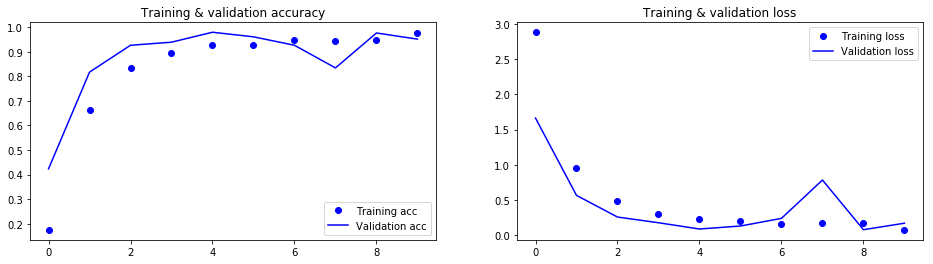

Generated 6999 predictions
0
Training took a total of 0:00:00.000001
TRAIN LOSS:  0.1396093780477531
TRAIN ACC:  0.9578125
VAL LOSS:  0.13036474920809268
VAL ACC:  0.9625


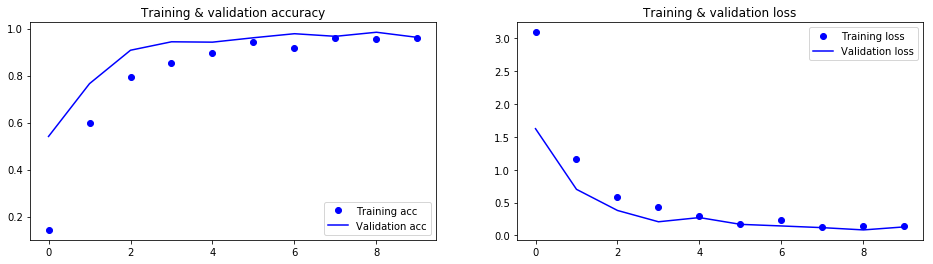

Generated 6999 predictions
1
Training took a total of 0:00:00.000001
TRAIN LOSS:  0.13013003404252232
TRAIN ACC:  0.9584375
VAL LOSS:  0.08343214226546902
VAL ACC:  0.9811320754716981


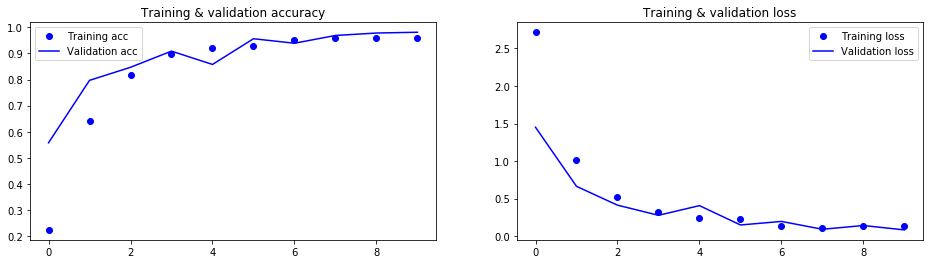

Generated 6999 predictions
2
Training took a total of 0:00:00.000001
TRAIN LOSS:  0.2004869964160025
TRAIN ACC:  0.938125
VAL LOSS:  0.16674868557602168
VAL ACC:  0.9421875


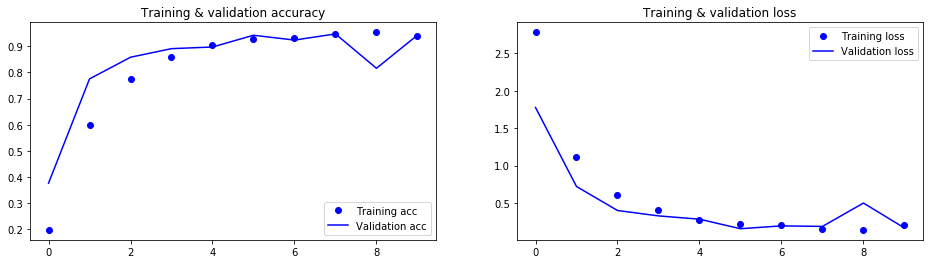

Generated 6999 predictions
3
Training took a total of 0:00:00.000001
TRAIN LOSS:  0.2723795136912764
TRAIN ACC:  0.920820189274448
VAL LOSS:  0.12767511438578366
VAL ACC:  0.959375


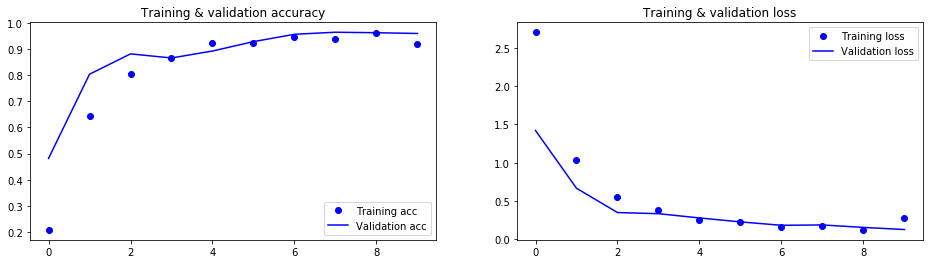

Generated 6999 predictions
4


In [354]:
for x in range(0,5):
    model_stats = rerun_final_model()
    model_runs.append(model_stats)
    print(x)

### Review Final Model Runs

In [357]:
final_model_df = pd.DataFrame(model_runs, columns = ['model', 'history', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'test_loss', 'test_acc', 'Y_pred', 'y_pred', 'classes'])
final_model_df

,model,history,train_loss,train_acc,val_loss,val_acc,test_loss,test_acc,Y_pred,y_pred,classes
0,<keras.engine.sequential.Sequential object at ...,<keras.callbacks.History object at 0x1a93da96a0>,0.076447,0.975625,0.171766,0.951562,0.106896,0.968424,"[[6.1144284e-10, 0.029447543, 3.6902168e-16, 6...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,<keras.engine.sequential.Sequential object at ...,<keras.callbacks.History object at 0x1a996de748>,0.139609,0.957812,0.130365,0.962500,0.147236,0.950993,"[[1.7459025e-19, 5.731159e-23, 1.3710076e-11, ...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,<keras.engine.sequential.Sequential object at ...,<keras.callbacks.History object at 0x1a9b05add8>,0.130130,0.958438,0.083432,0.981132,0.094121,0.972139,"[[1.1535251e-12, 3.068604e-14, 9.890039e-10, 2...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,<keras.engine.sequential.Sequential object at ...,<keras.callbacks.History object at 0x1aa1013ba8>,0.200487,0.938125,0.166749,0.942187,0.184350,0.938420,"[[1.12650445e-10, 2.2896694e-13, 4.979281e-10,...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,<keras.engine.sequential.Sequential object at ...,<keras.callbacks.History object at 0x1aa2e8def0>,0.272380,0.920820,0.127675,0.959375,0.145267,0.962137,"[[0.34303403, 0.0017397228, 4.3849508e-07, 6.1...","[28, 0, 0, 0, 0, 0, 0, 24, 28, 28, 0, 0, 0, 28...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [358]:
final_model_df.describe()

,train_loss,train_acc,val_loss,val_acc,test_loss,test_acc
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.163811,0.950164,0.135997,0.959351,0.135574,0.958423
std,0.074975,0.021102,0.035669,0.014488,0.035881,0.013759
min,0.076447,0.920820,0.083432,0.942187,0.094121,0.938420
25%,0.130130,0.938125,0.127675,0.951562,0.106896,0.950993
50%,0.139609,0.957812,0.130365,0.959375,0.145267,0.962137
75%,0.200487,0.958438,0.166749,0.962500,0.147236,0.968424
max,0.272380,0.975625,0.171766,0.981132,0.184350,0.972139


Running the model five times returns similar results, with training, validation, and test losses staying close to each other, and an average test accuracy of 95.8% and average test loss of 13.5%

### Save Final Models

In [438]:
x = 0
for m in model_runs:
    model = m['model']
    filename = 'final_model_' + str(x) + '.h5'
    model.save(filename)
    x += 1

### Review Confusion Matrix

Confusion matrix, without normalization


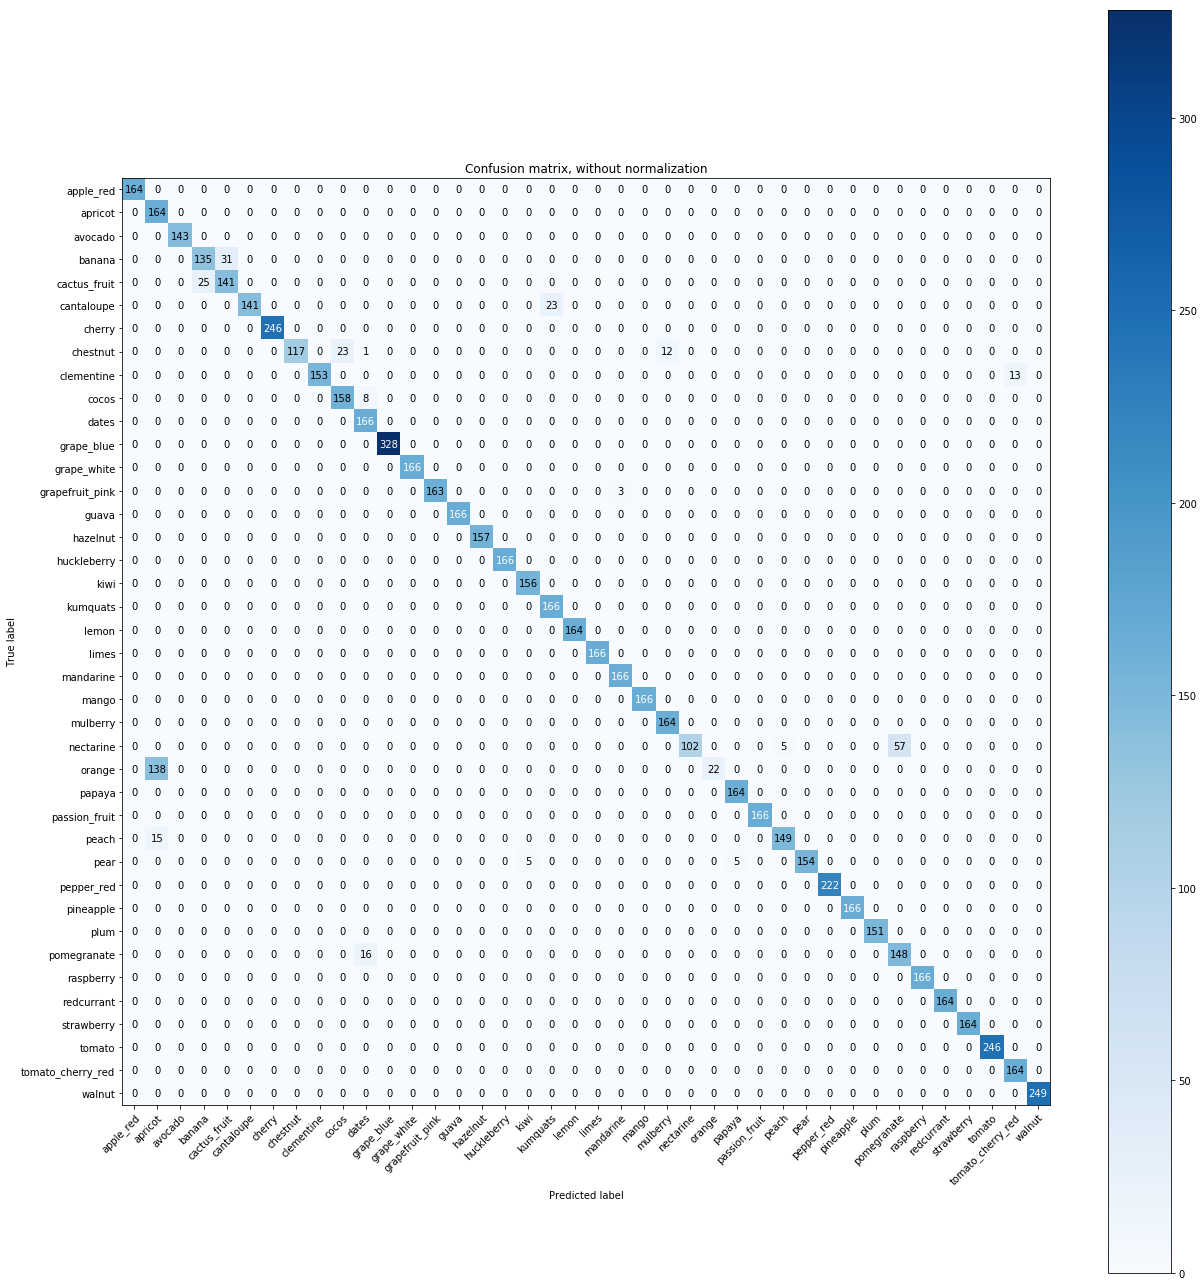

In [363]:
test_generator.reset()
Y_pred = model_02.predict_generator(test_generator, steps=len(test_generator))
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)

plot_confusion_matrix(test_generator.classes[test_generator.index_array], y_pred, classes=class_names)

Normalized confusion matrix


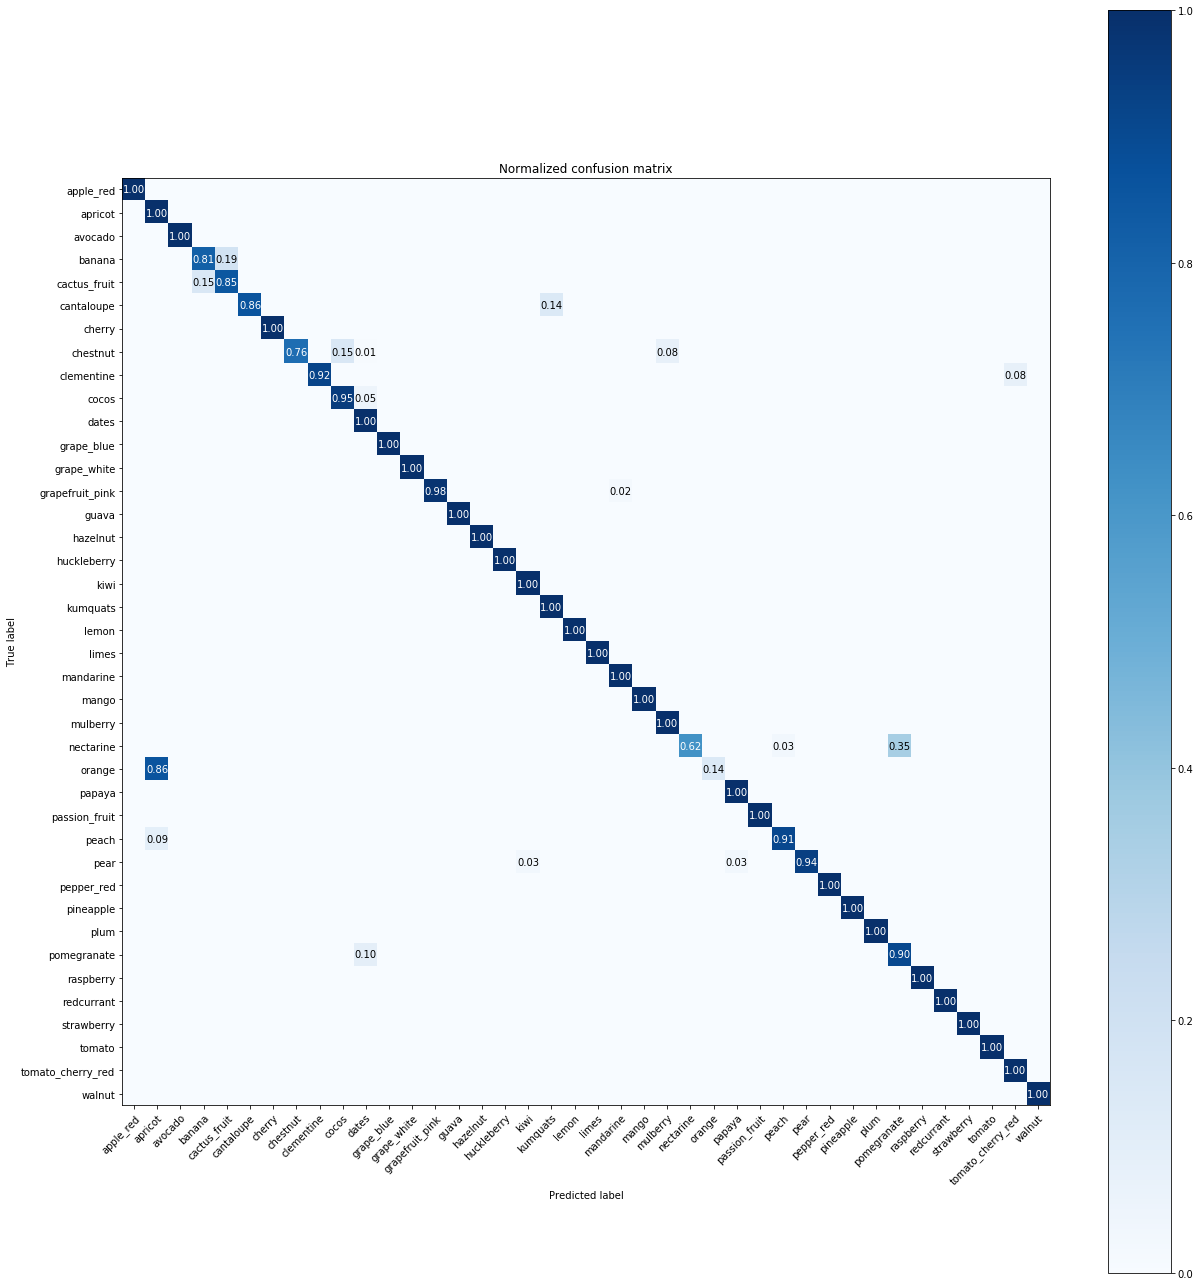

In [453]:
plot_confusion_matrix(test_generator.classes[test_generator.index_array], y_pred, classes=class_names, normalize=True)

#### Notable Predictions

In the test dataset:

- Out of the **160 Oranges**
    - **138 incorrectly predicted** as apricot (86.25%)
    - **22 correctly predicted** as orange (13.75%)
- Out of the **159 nectarines**
    - **57 incorrectly predicted** as pomegranate (35.8%)
    - **102 correctly predicted** as nectarine (64.2%)
- Out of the **164 pears**
    - **5 incorrectly predicted** as kiwi (3%)
    - **5 incorrecty predicted** as papaya (3%)
    - **154 correctly predicted** as pear (93.9%)
    
Interestingly, the prediction accuracy/error was not bidirectional. That is, though oranges were highly misclassified as nectarines, nectaries were not highly misclassified as oranges.  This was the case for all the predictions.

Additionally, only one fruit (pear) was misclassified as two different fruits (kiwi, papaya).  For every other fruit, all incorrect predictions were of the same class.

## Viewing Predictions

#### Sort Directories for Interactive Predictions

In [409]:
# sort folders for viewing predictions
sorted_dirs = sorted(list(listdir_nohidden('data/test')))

#### Interact: First 9 Images In Folder & View Prediction

In [448]:
@interact

def view_predictions(folder=sorted_dirs):
    folder_path = train_dir + '/' + folder
    imgs = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]
    imgs_10 = imgs[0:9] # get first 9 images
    f = plt.figure(figsize=(16,12))
    for i in range(9):        
        plt.subplot(330 + 1 + i)
        test_image = image.load_img(folder_path + '/' + imgs_10[i], target_size=(64,64,3))
        plt.imshow(test_image)
        test_image = image.img_to_array(test_image)
        test_image = test_image/255.0
        
        test_image = np.expand_dims(test_image, axis=0) # adding batch size as predict method expects
        result = model_02.predict(test_image)
        predicted_index = np.argmax(result)
    
        class_indices = test_generator.class_indices
        
        # get predicted label by finding value in class_indices dict
        predicted_label = list(class_indices.keys())[list(class_indices.values()).index(predicted_index)]
        img_label = folder
        
        # set labels, add ('INCORRECT') if misclassified
        xlabel = 'Pred: ' + predicted_label
        if predicted_label != img_label:
            xlabel += ' (INCORRECT)'
        plt.xlabel(xlabel)
        plt.ylabel('Act: ' + img_label)

    plt.show()

interactive(children=(Dropdown(description='folder', options=('apple_red', 'apricot', 'avocado', 'banana', 'ca…

In [437]:
evaluate_model_on_test(model_02, test_generator)

Generated 6999 predictions
Test Acc: 0.9457065295042149
Test Loss: 0.12304144031062987


# Takeaways

- Given the opportunity to start over, I would start from scratch. I learned a lot more going through this project than I learned in the actual module lessons or labs, so I am confident that the code would be cleaner and less repetitive, and the results would be more accurate.

- Without random seeding, the results of models fluctuate, so it's hard to really know when your model is truly well-prepared or merely lucky.  

- I settled on a model that had slightly lower testing accuracy than some of the other models I ran, but its loss was more in line with the training and validation losses.

- I would have liked to work on a binary image classifier, first, then ultimately on a multi-class classifier.


# Links

- [***Welcome to deep learning](https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99)
- [Keras.io - How CNNs see the wold](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
- [Kaggle - CNN - Whale Identification](https://www.kaggle.com/pestipeti/keras-cnn-starter)
- [Kaggle - CNN with Keras - Fashion](https://www.kaggle.com/bugraokcu/cnn-with-keras) 
- [Image Classification from scratch - TDS](https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9)
- [Tutorial flow_from_directory and generators](https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720)
- [Keras Conv2D and Convolutional Layers](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)
- [Guide to Convolutional Neural Networks](https://www.superdatascience.com/blogs/the-ultimate-guide-to-convolutional-neural-networks-cnn)
- [CNN with keras](https://www.kaggle.com/bugraokcu/cnn-with-keras)
- [CNN to Classify Dogs and Cats](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)
- [Stackoverflow - Underfitting/Overfitting/Good Fit](https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error/187404#187404)
- [Google Groups - Confusion Matrix - Test Generator](https://groups.google.com/forum/#!topic/keras-users/bqWwFox_zZs)
- [TDS - Image Classification Keras Tutorial: Dog Breed](https://towardsdatascience.com/image-classification-python-keras-tutorial-kaggle-challenge-45a6332a58b8)
- [Guide to CNN](https://skymind.ai/wiki/convolutional-network)
- [How to Choose Optimizer - Keras](https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras/)